## Import Library

In [1]:
%%time

import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# import statsmodels.api as sm
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error, mean_absolute_error

%matplotlib inline
warnings.filterwarnings('ignore')

CPU times: total: 1.27 s
Wall time: 15.5 s


In [2]:
# Load Data
df = pd.read_excel('D:\KINANTHI\KULIAH\TA\data\RekapanBulananLab.xlsx')
df = df[['date', 'bta_sputum', 'ns1_igg_igm']]

# Label data
Date='date'
LabelA='bta_sputum'
LabelB='ns1_igg_igm'

# Replace df
# df[LabelA] = df[LabelA].replace(0, 1).astype('int')
# df[LabelB] = df[LabelB].replace(0, 1).astype('int')

## Raw Data

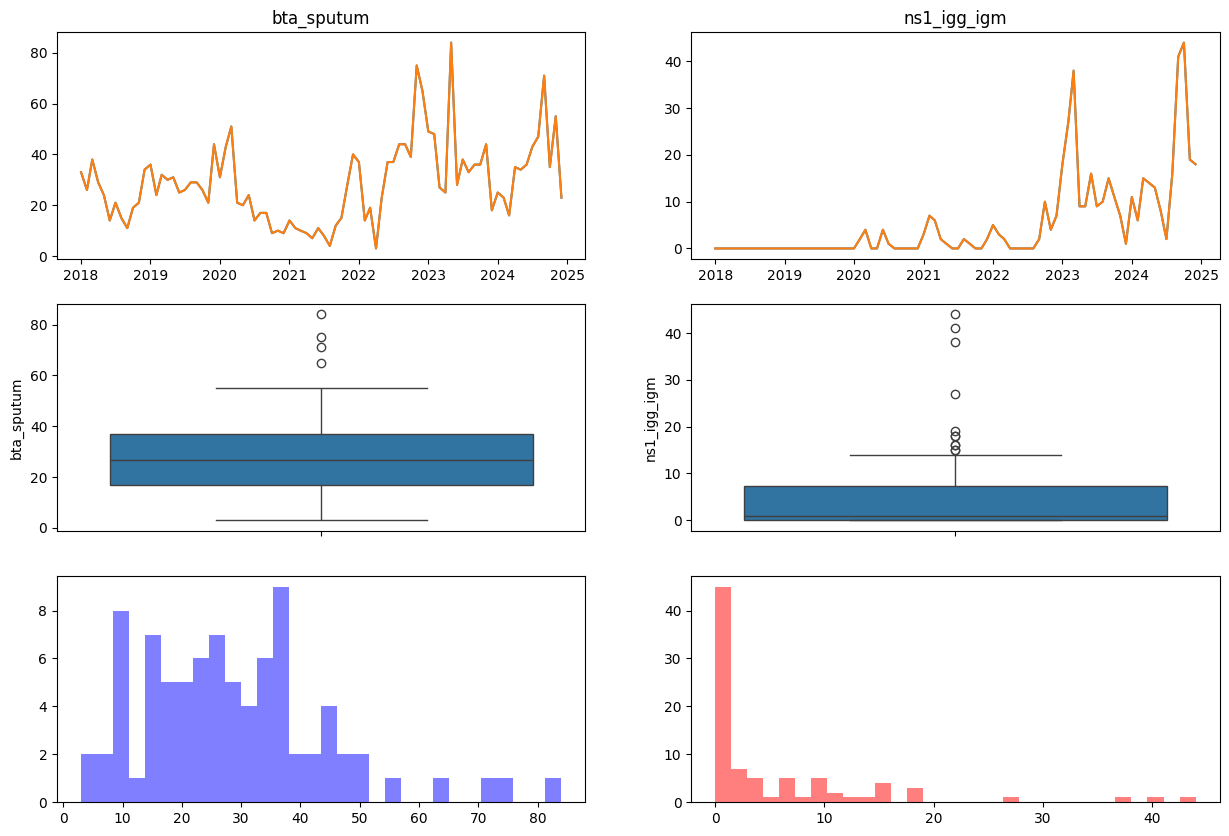

In [3]:
plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.plot(df[Date], df[LabelA], label='bta_sputum')
plt.plot(df[Date], df['bta_sputum'], label='bta_sputum')
plt.title('bta_sputum')

plt.subplot(3, 2, 2)
plt.plot(df[Date], df[LabelB], label='ns1_igg_igm')
plt.plot(df[Date], df['ns1_igg_igm'], label='ns1_igg_igm')
plt.title('ns1_igg_igm')

plt.subplot(3, 2, 3)
ax = sns.boxplot(df['bta_sputum'], whis=1)

plt.subplot(3, 2, 4)
ax = sns.boxplot(df['ns1_igg_igm'], whis=1)

plt.subplot(3, 2, 5)
plt.hist(df['bta_sputum'], bins=30, color='blue', alpha=0.5, label='bta_sputum')

plt.subplot(3, 2, 6)
plt.hist(df['ns1_igg_igm'], bins=30, color='red', alpha=0.5, label='ns1_igg_igm')

plt.show()

## Converting Data Type

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         84 non-null     datetime64[ns]
 1   bta_sputum   84 non-null     int64         
 2   ns1_igg_igm  84 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 2.1 KB


Each cols data type is already appropriate.

## Cleaning

In [5]:
def cleaning(df):
   
   df.drop_duplicates(inplace=True)
   missing_vals = df.isnull().sum()
   
   # menghapus kolom jika memiliki missing values >= 25%
   num_of_rows = int(len(df)/4)
   for column, missing_count in missing_vals.items():
      if missing_count >= num_of_rows:
         df.drop(column, axis=1, inplace=True)
         
   # mengganti nilai 0 dengan nilai minimal agar tidak mengganggu proses peramalan
   for col in df.columns:
      min_value = df[df[col] != 0][col].min()  # Cari nilai minimal yang bukan nol
      # mode_value = df[col].mode().iloc[0]  # Cari nilai modus
      df[col] = df[col].replace(0, min_value)
      
   updated_missing_vals = df.isnull().sum()
   df = df.reset_index(drop=True)
   
   return df, updated_missing_vals

data, missing_vals = cleaning(df)
missing_vals

date           0
bta_sputum     0
ns1_igg_igm    0
dtype: int64

## Forecast Error Measurement Function

In [6]:
# Hitung SMAPE
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    # Avoid division by zero
    denominator = np.where(denominator == 0, 1e-8, denominator)
    return np.mean(np.abs(y_true - y_pred) / denominator) * 100

# Evaluation function
def evaluate_forecast(y_true, y_pred, method_name, label):
    # Replace zeros to prevent divide-by-zero in MAPE
    y_true_safe = y_true.replace(0, np.nan)

    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)), 2)
    mae = round(mean_absolute_error(y_true, y_pred), 2)
    mape = np.mean(np.abs((y_true - y_pred) / y_true_safe)) * 100
    mape = round(mape, 2)
    smape_val = round(smape(y_true.values, y_pred.values), 2)

    result = pd.DataFrame({
        'Method': [method_name],
        'Type': [label],
        'RMSE': [rmse],
        'MAPE': [mape],
        'MAE': [mae],
        'SMAPE': [smape_val],
    })
    return result

def plot_forecast(train, test, forecast, label, title, transform=None):
    plt.plot(train, label='Train')
    
    plt.plot(test, label='Test')
    plt.plot(forecast, label='Forecast')

    plt.title(title)
    plt.tight_layout()
    plt.legend()

## Log Transform

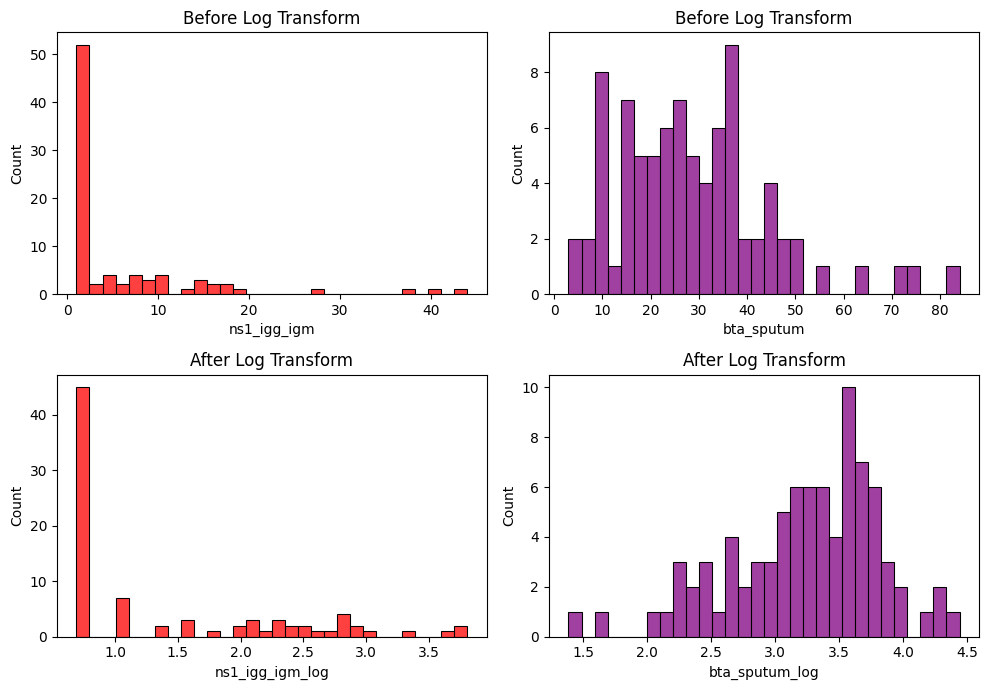

In [7]:
data['ns1_igg_igm_log'] = np.log1p(data['ns1_igg_igm'])
data['bta_sputum_log'] = np.log1p(data['bta_sputum'])

plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
sns.histplot(data['ns1_igg_igm'], bins=30, color='red')
plt.title('Before Log Transform')

plt.subplot(2, 2, 2)
sns.histplot(data['bta_sputum'], bins=30, color='purple')
plt.title('Before Log Transform')

plt.subplot(2, 2, 3)
sns.histplot(data['ns1_igg_igm_log'], bins=30, color='red')
plt.title('After Log Transform')

plt.subplot(2, 2, 4)
sns.histplot(data['bta_sputum_log'], bins=30, color='purple')
plt.title('After Log Transform')

plt.tight_layout()
plt.show()

## Capping Outlier

In [8]:
def cap_outliers(series, lower=0.05, upper=0.95):
    q_low = series.quantile(lower)
    q_high = series.quantile(upper)
    return np.clip(series, q_low, q_high)

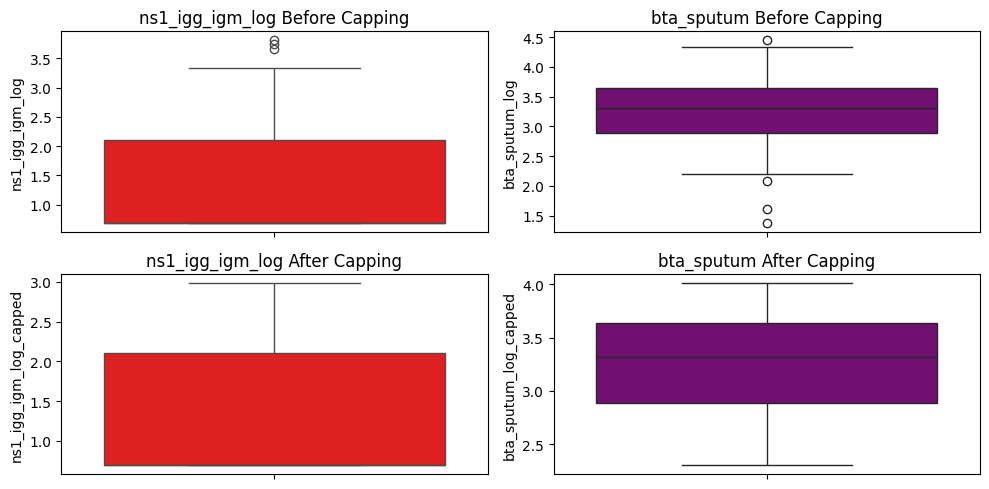

In [9]:
data['bta_sputum_log_capped'] = cap_outliers(data['bta_sputum_log'])
data['ns1_igg_igm_log_capped'] = cap_outliers(data['ns1_igg_igm_log'])

plt.figure(figsize=(10, 5))
plt.subplot(2, 2, 1)
sns.boxplot(data['ns1_igg_igm_log'], color="red", whis=1)
plt.title('ns1_igg_igm_log Before Capping')

plt.subplot(2, 2, 2)
sns.boxplot(data['bta_sputum_log'], color="purple", whis=1)
plt.title('bta_sputum Before Capping')

plt.subplot(2, 2, 3)
sns.boxplot(data['ns1_igg_igm_log_capped'], color="red", whis=1)
plt.title('ns1_igg_igm_log After Capping')

plt.subplot(2, 2, 4)
sns.boxplot(data['bta_sputum_log_capped'], color="purple", whis=1)
plt.title('bta_sputum After Capping')

plt.tight_layout()
plt.show()

## After Preprocessing

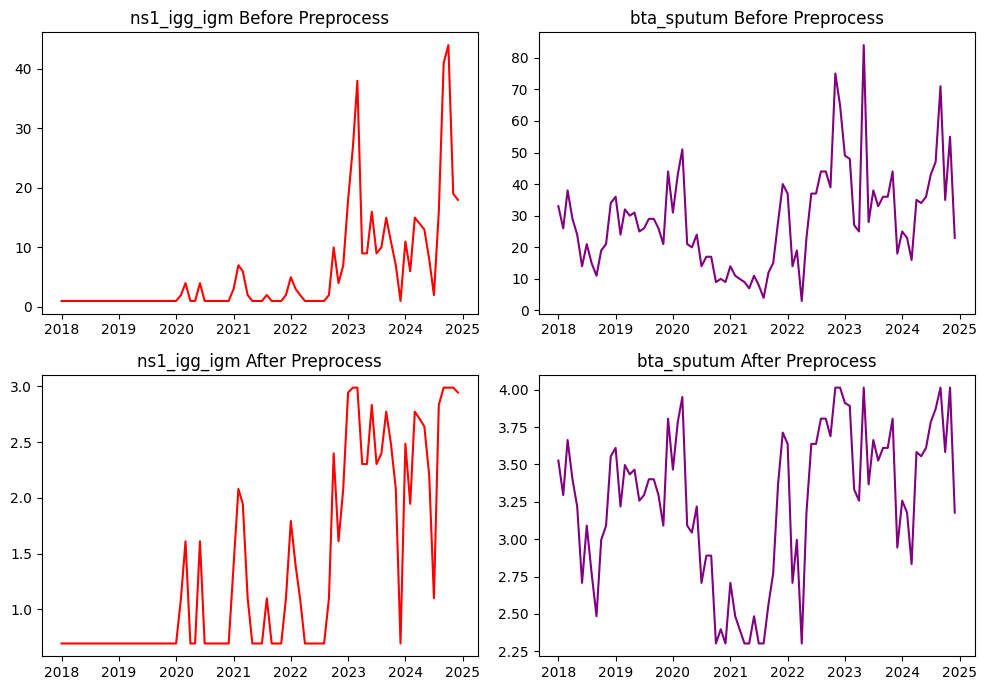

In [10]:
plt.figure(figsize=(10,7))

plt.subplot(2, 2, 1)
plt.plot(data[Date], data[LabelB], label='ns1_igg_igm', color='red')
plt.title('ns1_igg_igm Before Preprocess')

plt.subplot(2, 2, 2)
plt.plot(data[Date], data[LabelA], label='bta_sputum', color='purple')
plt.title('bta_sputum Before Preprocess')

plt.subplot(2, 2, 3)
plt.plot(data[Date], data['ns1_igg_igm_log_capped'], label='ns1_igg_igm', color='red')
plt.title('ns1_igg_igm After Preprocess')

plt.subplot(2, 2, 4)
plt.plot(data[Date], data['bta_sputum_log_capped'], label='bta_sputum', color='purple')
plt.title('bta_sputum After Preprocess')

plt.tight_layout()
plt.show()


In [11]:
data['date'] = pd.to_datetime(data['date'])
data.head()


# Label Data baru setelah di log dan cap
Date='date'
LabelA='bta_sputum_log_capped'
LabelB='ns1_igg_igm_log_capped'
data.head()

date  bta_sputum  ns1_igg_igm  ns1_igg_igm_log  bta_sputum_log  \
0 2018-01-01          33            1         0.693147        3.526361   
1 2018-02-01          26            1         0.693147        3.295837   
2 2018-03-01          38            1         0.693147        3.663562   
3 2018-04-01          29            1         0.693147        3.401197   
4 2018-05-01          24            1         0.693147        3.218876   

   bta_sputum_log_capped  ns1_igg_igm_log_capped  
0               3.526361                0.693147  
1               3.295837                0.693147  
2               3.663562                0.693147  
3               3.401197                0.693147  
4               3.218876                0.693147

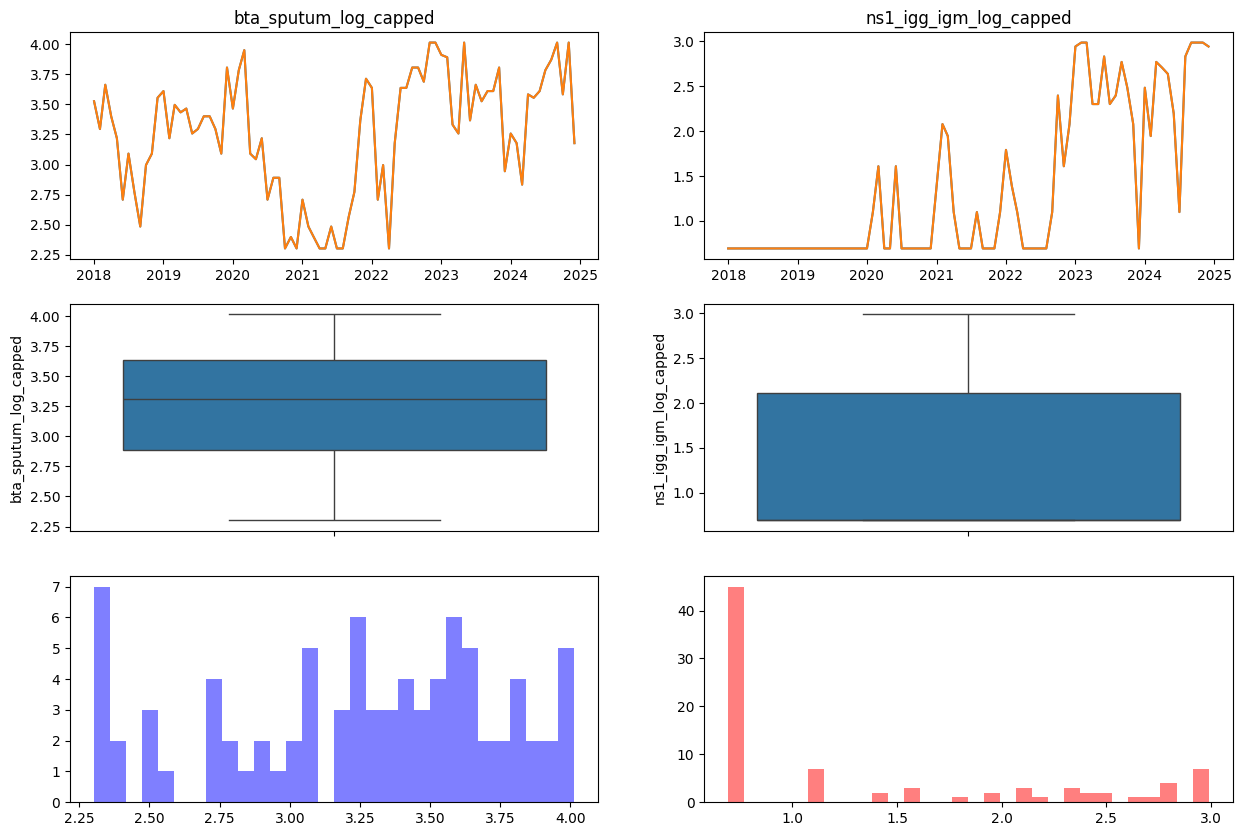

In [12]:
plt.figure(figsize=(15,10))

plt.subplot(3, 2, 1)
plt.plot(data[Date], data[LabelA], label='bta_sputum_log_capped')
plt.plot(data[Date], data['bta_sputum_log_capped'], label='bta_sputum_log_capped')
plt.title('bta_sputum_log_capped')

plt.subplot(3, 2, 2)
plt.plot(data[Date], data[LabelB], label='ns1_igg_igm_log_capped')
plt.plot(data[Date], data['ns1_igg_igm_log_capped'], label='ns1_igg_igm_log_capped')
plt.title('ns1_igg_igm_log_capped')

plt.subplot(3, 2, 3)
ax = sns.boxplot(data['bta_sputum_log_capped'], whis=1)

plt.subplot(3, 2, 4)
ax = sns.boxplot(data['ns1_igg_igm_log_capped'], whis=1)

plt.subplot(3, 2, 5)
plt.hist(data['bta_sputum_log_capped'], bins=30, color='blue', alpha=0.5, label='bta_sputum_log_capped')

plt.subplot(3, 2, 6)
plt.hist(data['ns1_igg_igm_log_capped'], bins=30, color='red', alpha=0.5, label='ns1_igg_igm_log_capped')

plt.show()

In [13]:
data

date  bta_sputum  ns1_igg_igm  ns1_igg_igm_log  bta_sputum_log  \
0  2018-01-01          33            1         0.693147        3.526361   
1  2018-02-01          26            1         0.693147        3.295837   
2  2018-03-01          38            1         0.693147        3.663562   
3  2018-04-01          29            1         0.693147        3.401197   
4  2018-05-01          24            1         0.693147        3.218876   
..        ...         ...          ...              ...             ...   
79 2024-08-01          47           16         2.833213        3.871201   
80 2024-09-01          71           41         3.737670        4.276666   
81 2024-10-01          35           44         3.806662        3.583519   
82 2024-11-01          55           19         2.995732        4.025352   
83 2024-12-01          23           18         2.944439        3.178054   

    bta_sputum_log_capped  ns1_igg_igm_log_capped  
0                3.526361                0.693147  
1                3.295837                0.693147  
2                3.663562                0.693147  
3                3.401197                0.693147  
4                3.218876                0.693147  
..                    ...                     ...  
79               3.871201                2.833213  
80               4.014235                2.988038  
81               3.583519                2.988038  
82               4.014235                2.988038  
83               3.178054                2.944439  

[84 rows x 7 columns]

## TSCV

In [14]:
# # Initial Modeling
# # n_splits 7 agar sesuai dengan jumlah data, yaitu 7 tahun
tscv = TimeSeriesSplit(n_splits=6)
results = pd.DataFrame(columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])
naive_pred = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
avr_pred = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
single_pred = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
double_pred_add = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
double_pred_mul = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
triple_pred_add_add = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
triple_pred_add_mul = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
triple_pred_mul_add = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
triple_pred_mul_mul = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
arima_pred = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])
sarima_pred = pd.DataFrame(columns=['date', 'predictions_BTA', 'predictions_NS1'])

## Naive Bayes Forecast

In [15]:
# List
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

In [16]:
for train_idx, val_idx in tscv.split(data):
    # Split data
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    # Proses Naive Forecasting
    y_hat_naive = val_split.copy()
    y_hat_naive['Naive_BTA'] = train_split[LabelA].iloc[-1]
    y_hat_naive['Naive_NS1'] = train_split[LabelB].iloc[-1]
    
    # Evaluate Naive Forecasting
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_naive['Naive_BTA'], 'Naive', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_naive['Naive_NS1'], 'Naive', LabelB)
    
    # Masukin ke list untuk merata ratakan hasil
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    # Masukin ke list untuk memprediksi
    y_hat_naive['date'] = val_split.index
    y_hat_naive['predictions_BTA'] = y_hat_naive['Naive_BTA']
    y_hat_naive['predictions_NS1'] = y_hat_naive['Naive_NS1']
    
    naive_pred = pd.concat([naive_pred, y_hat_naive[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    naive_pred = naive_pred.drop_duplicates(subset=['date'], keep='last')
    naive_pred = naive_pred.sort_values('date')
    naive_pred = naive_pred.reset_index(drop=True)

In [17]:
# Hitung Average
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

# Hasil
average_results = pd.DataFrame([['Naive', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['Naive', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE      SMAPE
0  Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000  14.351667
1  Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667  37.953333

In [18]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
naive_pred[cols_to_inverse] = naive_pred[cols_to_inverse].apply(np.expm1)
naive_pred.reset_index(drop=True, inplace=True)
naive_pred

date  predictions_BTA  predictions_NS1
0    12             34.0              1.0
1    13             34.0              1.0
2    14             34.0              1.0
3    15             34.0              1.0
4    16             34.0              1.0
..  ...              ...              ...
67   79             18.0              1.0
68   80             18.0              1.0
69   81             18.0              1.0
70   82             18.0              1.0
71   83             18.0              1.0

[72 rows x 3 columns]

## Average Forecast

In [19]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

In [20]:
for train_idx, val_idx in tscv.split(data):
    
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    y_hat_avg = val_split.copy()
    y_hat_avg['AVG_BTA'] = data[LabelA].mean()
    y_hat_avg['AVG_NS1'] = data[LabelB].mean()
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_avg['AVG_BTA'], 'Average', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_avg['AVG_NS1'], 'Average', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_avg['date'] = val_split.index
    y_hat_avg['predictions_BTA'] = y_hat_avg['AVG_BTA']
    y_hat_avg['predictions_NS1'] = y_hat_avg['AVG_NS1']
    
    avr_pred = pd.concat([avr_pred, y_hat_avg[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    avr_pred = avr_pred.drop_duplicates(subset=['date'], keep='last')
    avr_pred = avr_pred.sort_values('date')
    avr_pred = avr_pred.reset_index(drop=True)
    

In [21]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['Average', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['Average', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE      SMAPE
0    Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000  14.351667
1    Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667  37.953333
2  Average   bta_sputum_log_capped  0.500000  14.545000  0.440000  13.838333
3  Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000  54.600000

In [22]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
avr_pred[cols_to_inverse] = avr_pred[cols_to_inverse].apply(np.expm1)
avr_pred.reset_index(drop=True, inplace=True)
avr_pred

date  predictions_BTA  predictions_NS1
0    12        24.840553         2.915867
1    13        24.840553         2.915867
2    14        24.840553         2.915867
3    15        24.840553         2.915867
4    16        24.840553         2.915867
..  ...              ...              ...
67   79        24.840553         2.915867
68   80        24.840553         2.915867
69   81        24.840553         2.915867
70   82        24.840553         2.915867
71   83        24.840553         2.915867

[72 rows x 3 columns]

## Single Exponential Smoothing

In [23]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:   Method                    Type  RMSE  MAPE  MAE  SMAPE
0    SES  ns1_igg_igm_log_capped   0.0   0.0  0.0    0.0, MAPE BTA:   Method                   Type  RMSE  MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.18   4.2  0.14   4.17


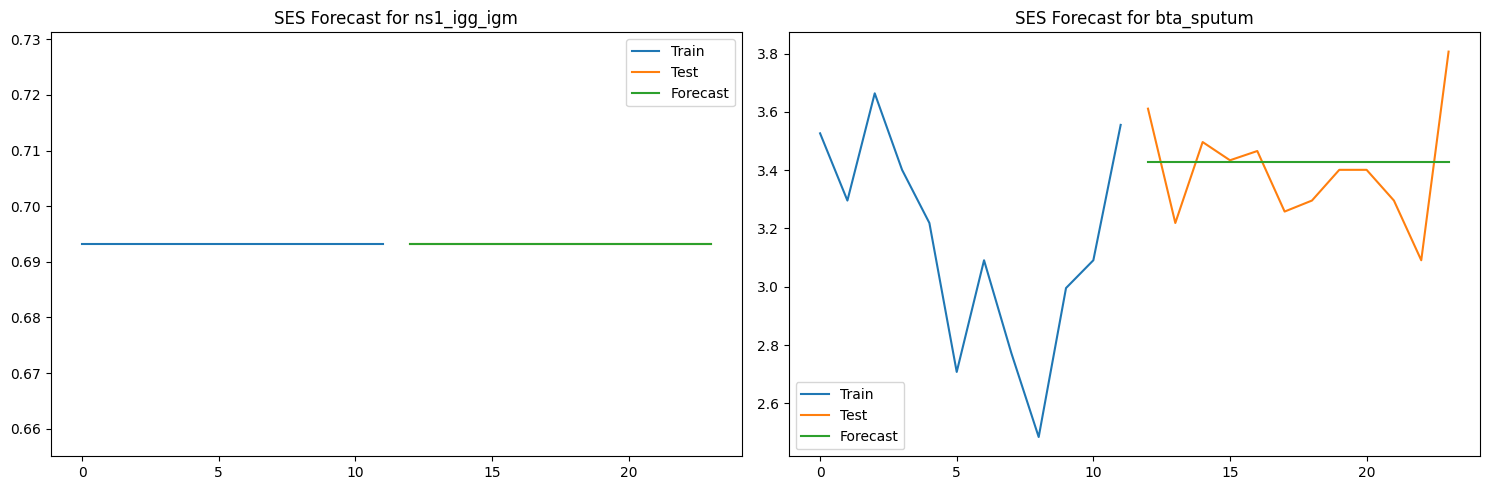

Fold: 2, Train: 24, Validation: 12
MAPE NS1:   Method                    Type  RMSE   MAPE   MAE  SMAPE
0    SES  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:   Method                   Type  RMSE   MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.77  24.95  0.66   21.2


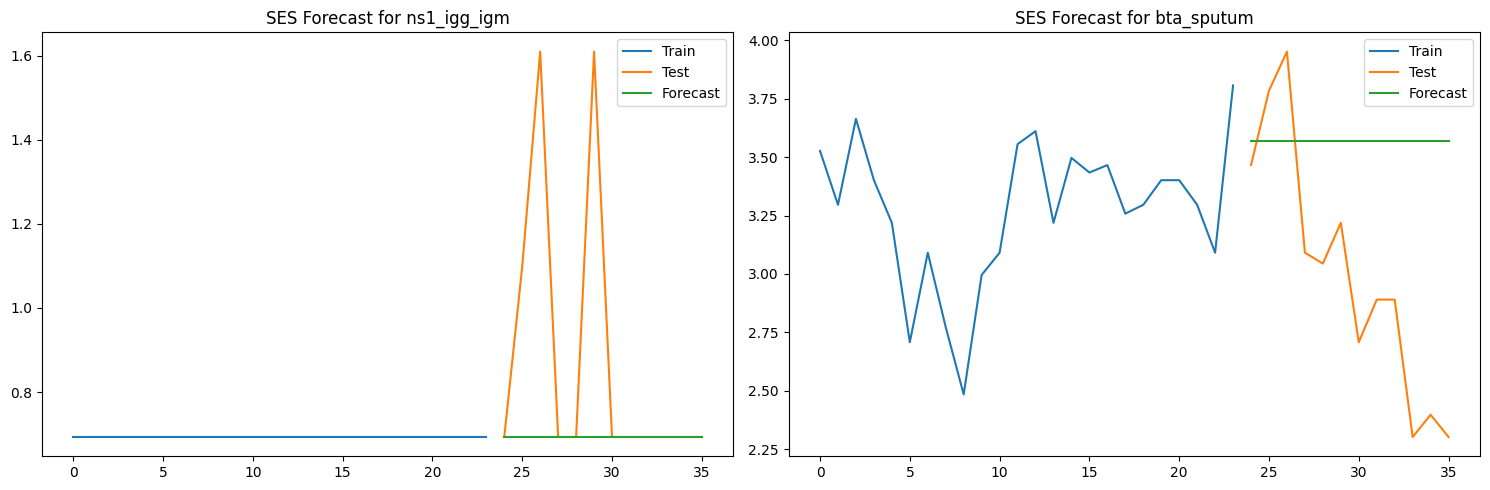

Fold: 3, Train: 36, Validation: 12
MAPE NS1:   Method                    Type  RMSE   MAPE   MAE  SMAPE
0    SES  ns1_igg_igm_log_capped  0.56  27.65  0.38  33.79, MAPE BTA:   Method                   Type  RMSE   MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.53  10.44  0.32  11.83


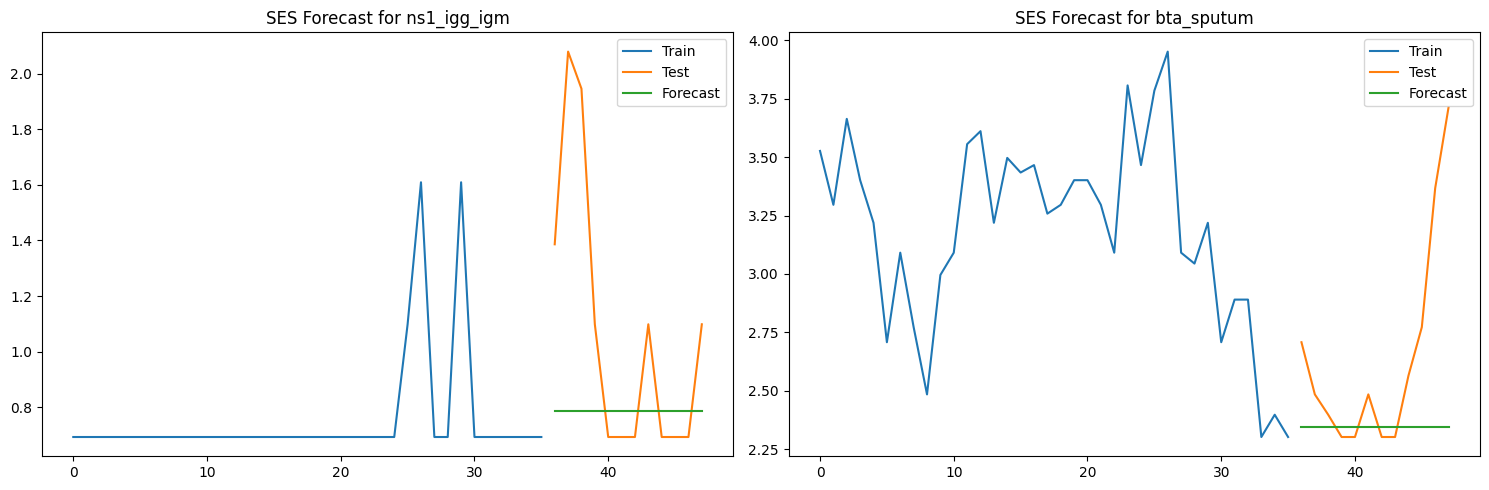

Fold: 4, Train: 48, Validation: 12
MAPE NS1:   Method                    Type  RMSE  MAPE   MAE  SMAPE
0    SES  ns1_igg_igm_log_capped  0.64  37.5  0.51   41.2, MAPE BTA:   Method                   Type  RMSE   MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.54  13.26  0.38   11.7


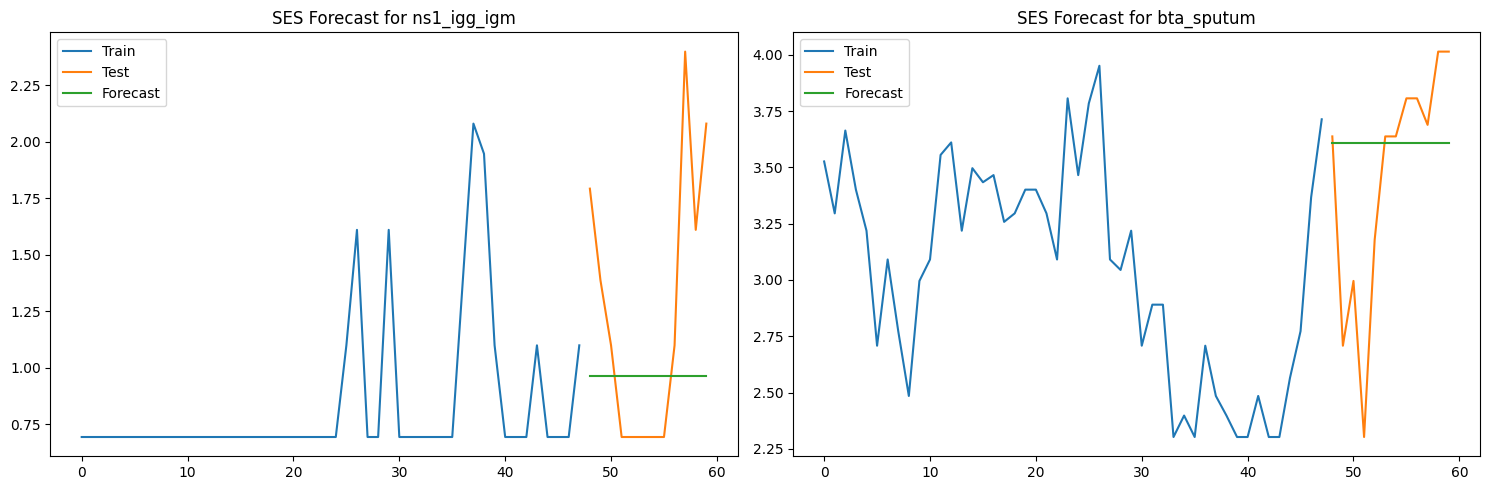

Fold: 5, Train: 60, Validation: 12
MAPE NS1:   Method                    Type  RMSE   MAPE   MAE  SMAPE
0    SES  ns1_igg_igm_log_capped  0.74  35.29  0.64  30.61, MAPE BTA:   Method                   Type  RMSE   MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.52  12.61  0.42  11.47


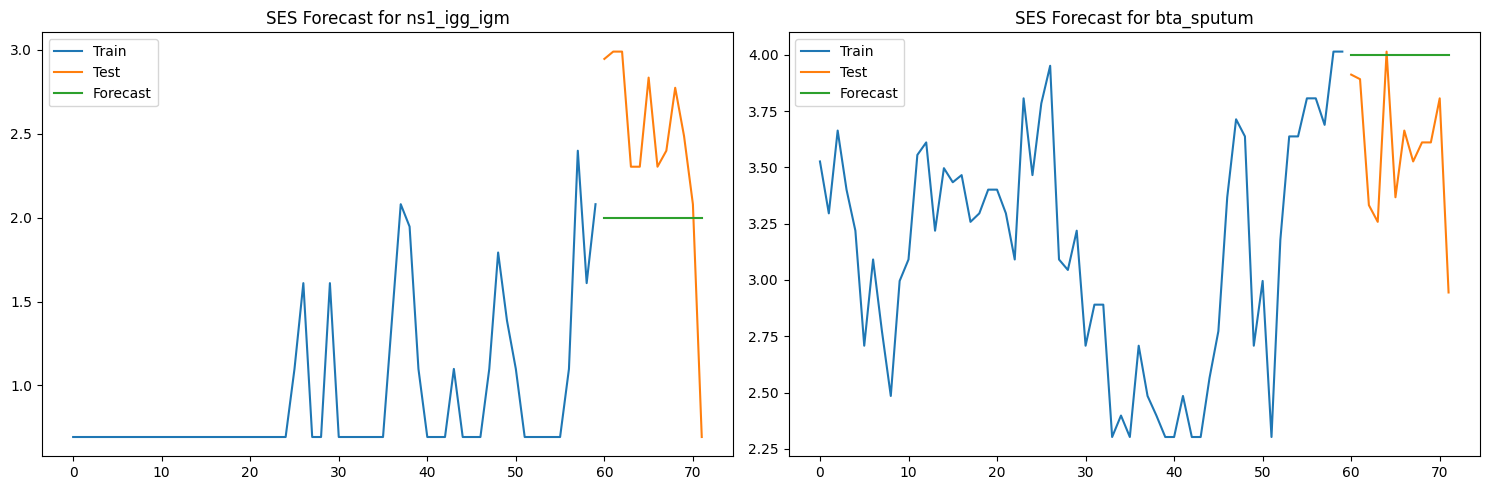

Fold: 6, Train: 72, Validation: 12
MAPE NS1:   Method                    Type  RMSE   MAPE   MAE   SMAPE
0    SES  ns1_igg_igm_log_capped  1.85  67.01  1.77  102.85, MAPE BTA:   Method                   Type  RMSE   MAPE   MAE  SMAPE
0    SES  bta_sputum_log_capped  0.49  11.01  0.41  11.77


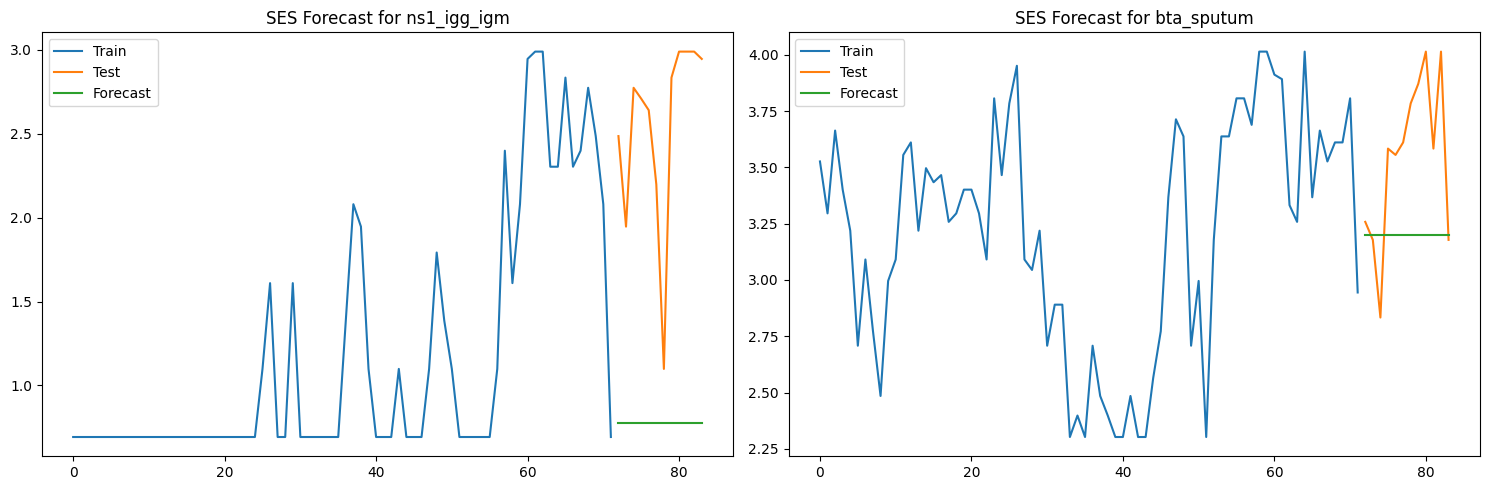

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.678712              NaN   
1  ns1_igg_igm_log_capped         0.939806              NaN   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0                 NaN            NaN       3.526361            NaN   
1                 NaN            NaN       0.693147            NaN   

  initial_seasons  use_boxcox lamda  remove_bias  
0              []       False  None        False  
1              []       False  None        False

In [24]:
for train_idx, val_idx in tscv.split(data):
    # Split data
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    # Modeling
    model1 = SimpleExpSmoothing(train_split[LabelA])
    model2 = SimpleExpSmoothing(train_split[LabelB])
    
    # Fit the model
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    # Proses Forecasting
    y_hat_ses = val_split.copy()
    y_hat_ses['SES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_ses['SES_NS1'] = model_fit2.forecast(len(val_split))
    
    # Evaluate Forecasting
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_ses['SES_BTA'], 'SES', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_ses['SES_NS1'], 'SES', LabelB)
    
    # Masukin ke list untuk merata ratakan hasil
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    # Masukin ke list untuk memprediksi
    y_hat_ses['date'] = val_split.index
    y_hat_ses['predictions_BTA'] = y_hat_ses['SES_BTA']
    y_hat_ses['predictions_NS1'] = y_hat_ses['SES_NS1']
    
    single_pred = pd.concat([single_pred, y_hat_ses[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    single_pred = single_pred.drop_duplicates(subset=['date'], keep='last')
    single_pred = single_pred.sort_values('date')
    single_pred = single_pred.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('SES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_ses['SES_NS1'], LabelB, 'SES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_ses['SES_BTA'], LabelA, 'SES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()
    
params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [25]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['SES', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['SES', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE      SMAPE
0    Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000  14.351667
1    Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667  37.953333
2  Average   bta_sputum_log_capped  0.500000  14.545000  0.440000  13.838333
3  Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000  54.600000
4      SES   bta_sputum_log_capped  0.505000  12.745000  0.388333  12.023333
5      SES  ns1_igg_igm_log_capped  0.696667  30.001667  0.581667  37.581667

In [26]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
single_pred[cols_to_inverse] = single_pred[cols_to_inverse].apply(np.expm1)
single_pred.reset_index(drop=True, inplace=True)
single_pred

date  predictions_BTA  predictions_NS1
0    12        29.796331         1.000000
1    13        29.796331         1.000000
2    14        29.796331         1.000000
3    15        29.796331         1.000000
4    16        29.796331         1.000000
..  ...              ...              ...
67   79        23.548485         1.177377
68   80        23.548485         1.177377
69   81        23.548485         1.177377
70   82        23.548485         1.177377
71   83        23.548485         1.177377

[72 rows x 3 columns]

In [27]:
single_pred.to_excel("single_pred_2024.xlsx")
with pd.ExcelWriter("D:\\KINANTHI\\KULIAH\\TA\\data_new\\single_pred_2024.xlsx", date_format='yyyy-mm-dd') as writer:
   single_pred.to_excel(writer, index=False)

## Double Exponential Smoothing

### Double Exp Smoothing Add

In [28]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:     Method                    Type  RMSE  MAPE  MAE  SMAPE
0  DES_ADD  ns1_igg_igm_log_capped   0.0   0.0  0.0    0.0, MAPE BTA:     Method                   Type  RMSE  MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped  0.18  4.01  0.14   4.04


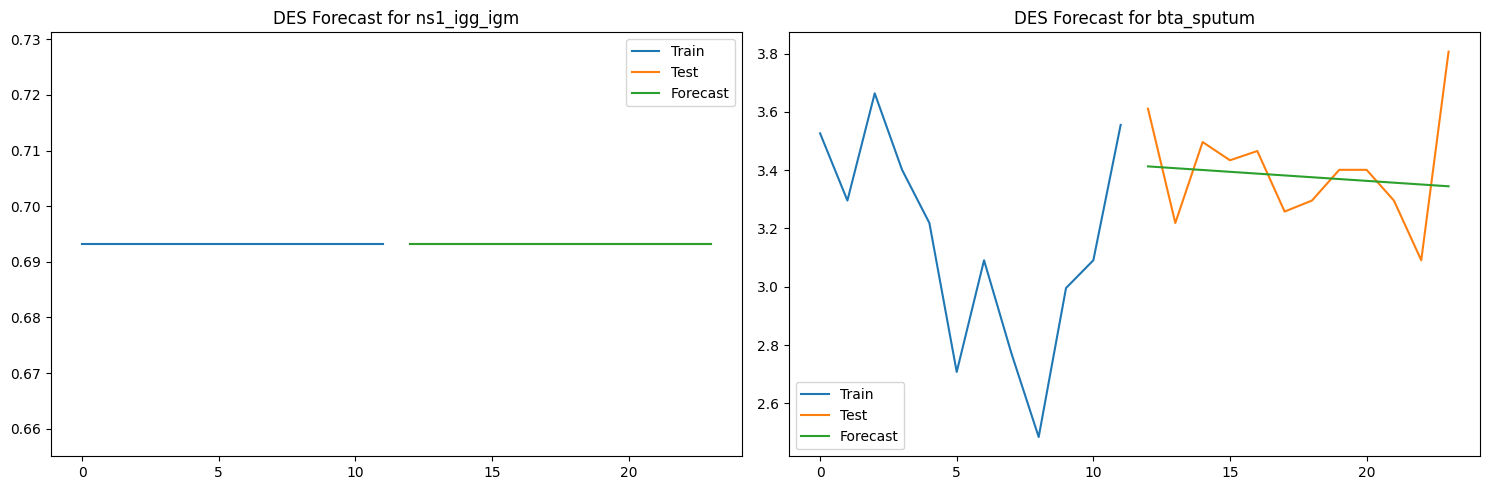

Fold: 2, Train: 24, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped   0.8  25.94  0.69  21.89


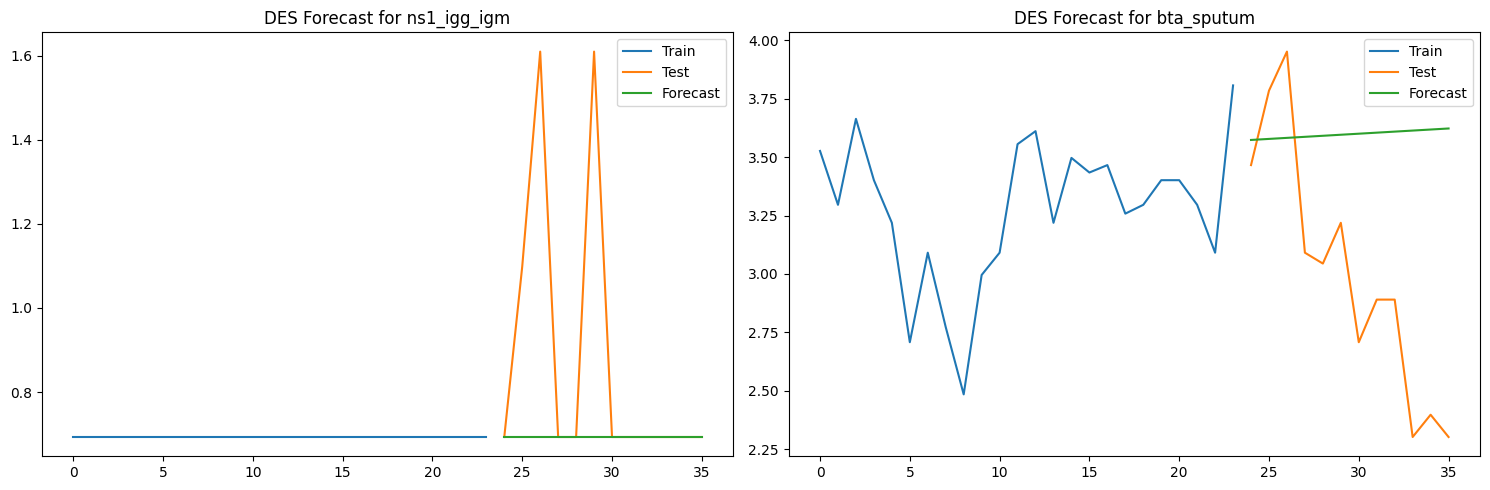

Fold: 3, Train: 36, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  ns1_igg_igm_log_capped  0.52  31.89  0.39  35.04, MAPE BTA:     Method                   Type  RMSE  MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped  0.73  17.6  0.52  20.67


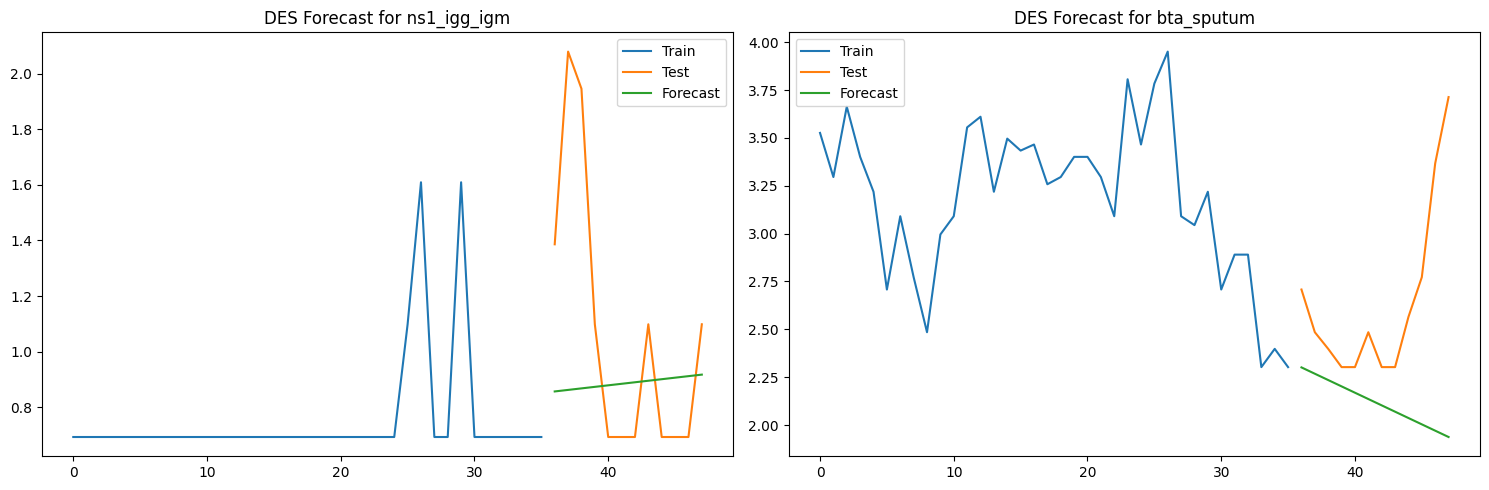

Fold: 4, Train: 48, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE  MAE  SMAPE
0  DES_ADD  ns1_igg_igm_log_capped  0.62  38.23  0.5  40.43, MAPE BTA:     Method                   Type  RMSE  MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped  0.54  13.0  0.37   11.4


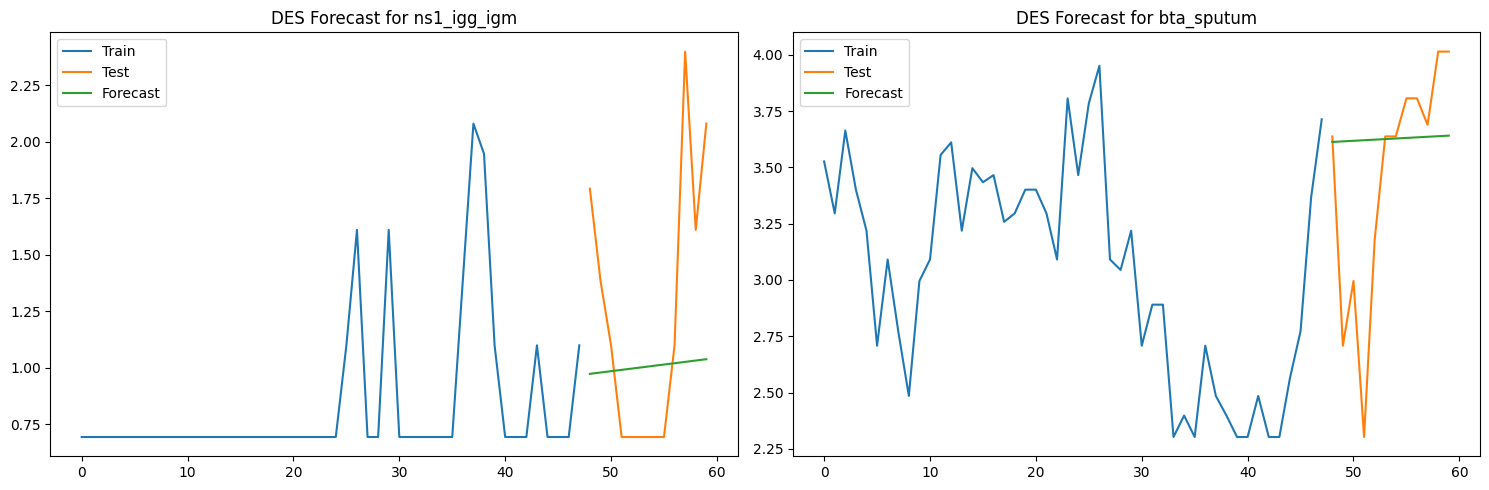

Fold: 5, Train: 60, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  ns1_igg_igm_log_capped  0.71  34.77  0.57  26.74, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped  0.57  14.25  0.48  12.87


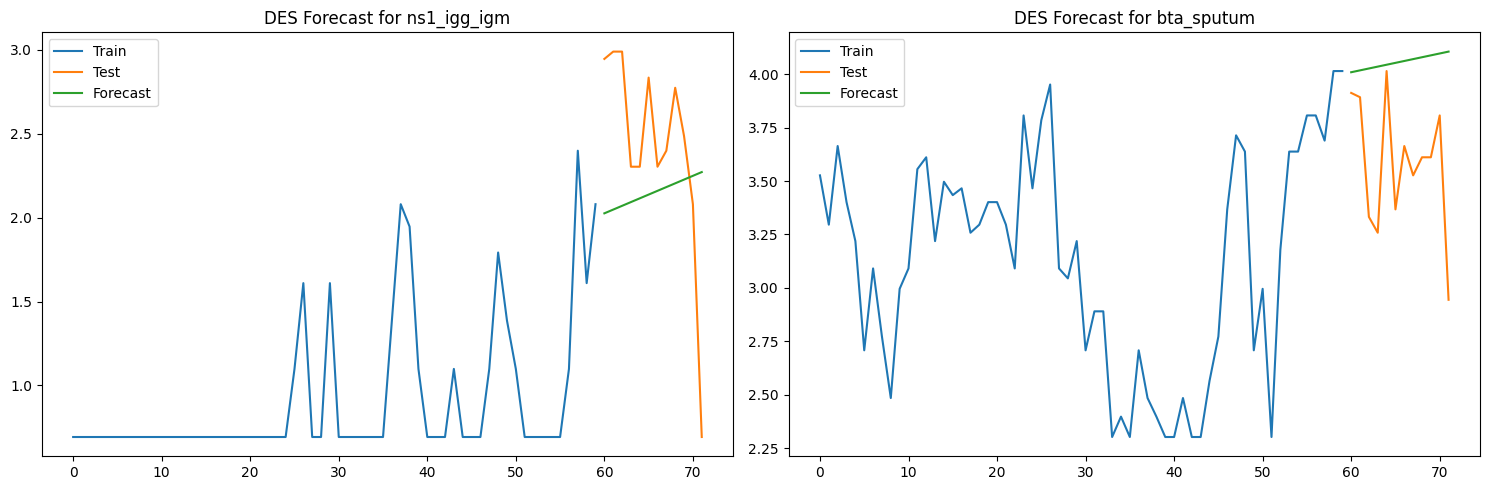

Fold: 6, Train: 72, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE   SMAPE
0  DES_ADD  ns1_igg_igm_log_capped  1.84  66.65  1.76  102.05, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_ADD  bta_sputum_log_capped  0.51  11.52  0.43  12.38


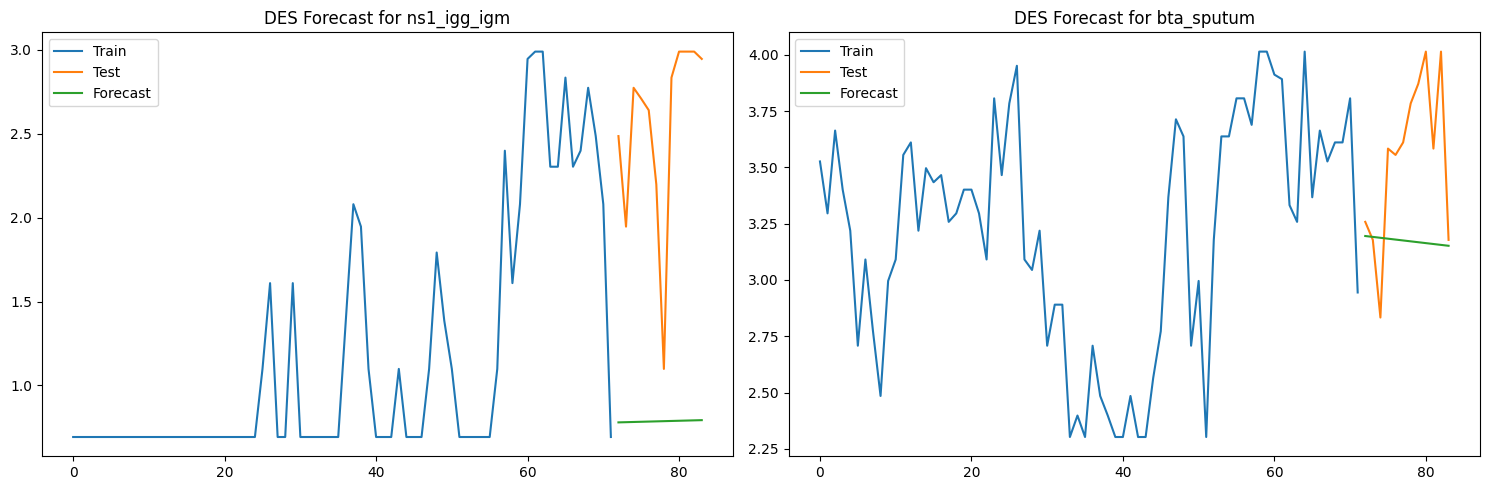

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.678208     4.345722e-18   
1  ns1_igg_igm_log_capped         0.939241     5.667911e-13   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0                 NaN            NaN       3.483963      -0.003941   
1                 NaN            NaN       0.691845       0.001209   

  initial_seasons  use_boxcox lamda  remove_bias  
0              []       False  None        False  
1              []       False  None        False

In [29]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], trend='add', seasonal=None)
    model2 = ExponentialSmoothing(train_split[LabelB], trend='add', seasonal=None)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['DES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['DES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['DES_BTA'], 'DES_ADD', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['DES_NS1'], 'DES_ADD', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['DES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['DES_NS1']
    
    double_pred_add = pd.concat([double_pred_add, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    double_pred_add = double_pred_add.drop_duplicates(subset=['date'], keep='last')
    double_pred_add = double_pred_add.sort_values('date')
    double_pred_add = double_pred_add.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('DES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['DES_NS1'], LabelB, 'DES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['DES_BTA'], LabelA, 'DES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()
    
params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [30]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['DES_ADD', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['DES_ADD', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE      SMAPE
0    Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000  14.351667
1    Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667  37.953333
2  Average   bta_sputum_log_capped  0.500000  14.545000  0.440000  13.838333
3  Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000  54.600000
4      SES   bta_sputum_log_capped  0.505000  12.745000  0.388333  12.023333
5      SES  ns1_igg_igm_log_capped  0.696667  30.001667  0.581667  37.581667
6  DES_ADD   bta_sputum_log_capped  0.555000  14.386667  0.438333  13.875000
7  DES_ADD  ns1_igg_igm_log_capped  0.680000  30.683333  0.568333  36.883333

In [31]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
double_pred_add[cols_to_inverse] = double_pred_add[cols_to_inverse].apply(np.expm1)
double_pred_add.reset_index(drop=True, inplace=True)
double_pred_add

date  predictions_BTA  predictions_NS1
0    12        29.356659         1.000000
1    13        29.168852         1.000000
2    14        28.982207         1.000000
3    15        28.796717         1.000000
4    16        28.612374         1.000000
..  ...              ...              ...
67   79        22.750935         1.200501
68   80        22.657522         1.203163
69   81        22.564477         1.205829
70   82        22.471798         1.208498
71   83        22.379484         1.211170

[72 rows x 3 columns]

### Double Exp Smoothing Mul

In [32]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:     Method                    Type  RMSE  MAPE  MAE  SMAPE
0  DES_MUL  ns1_igg_igm_log_capped   0.0   0.0  0.0    0.0, MAPE BTA:     Method                   Type  RMSE    MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  4.48  110.04  3.72  63.41


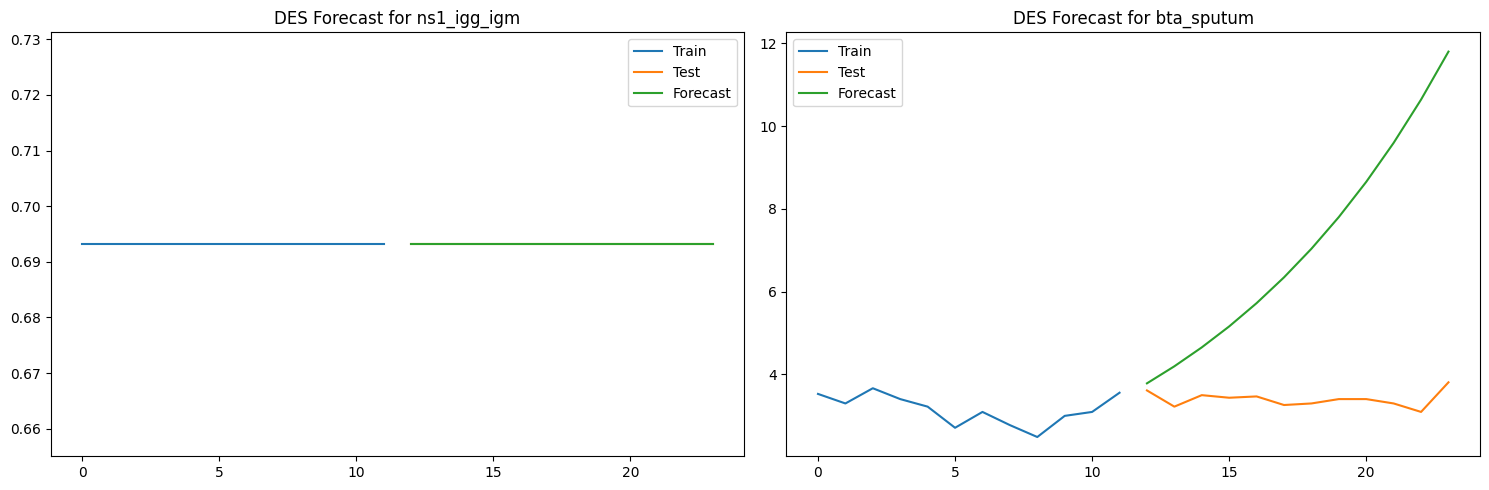

Fold: 2, Train: 24, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  0.76  24.74  0.66  21.05


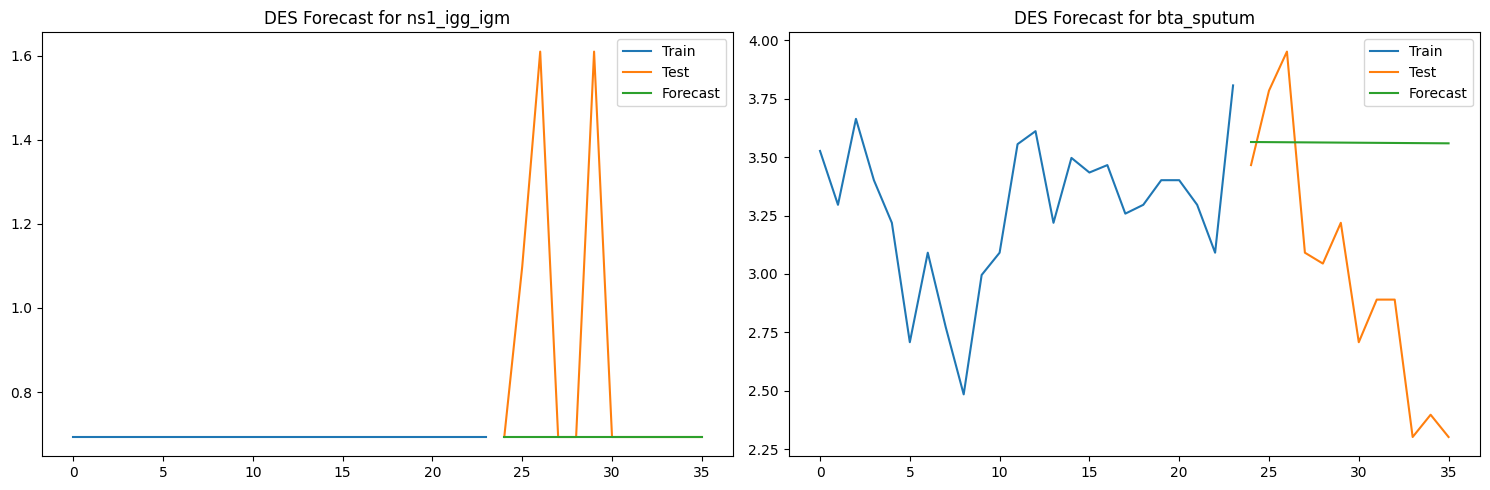

Fold: 3, Train: 36, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  ns1_igg_igm_log_capped  0.52  32.29  0.39  35.19, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  0.68  15.63  0.47  18.19


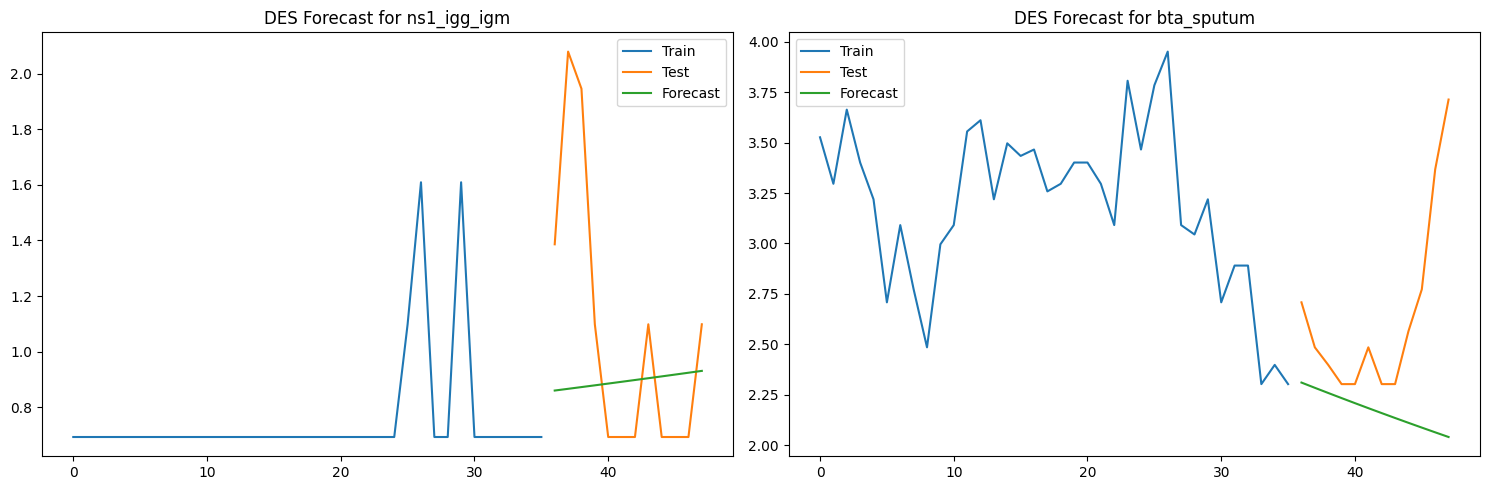

Fold: 4, Train: 48, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  ns1_igg_igm_log_capped  0.76  34.25  0.54  44.36, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  0.55  14.06  0.42  12.67


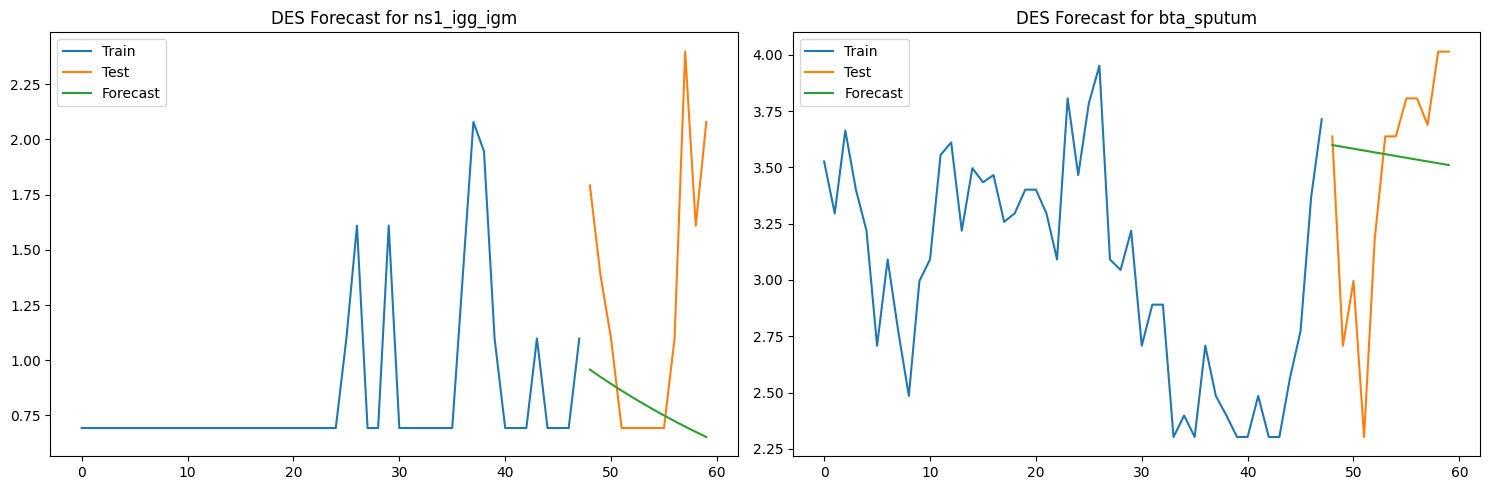

Fold: 5, Train: 60, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  ns1_igg_igm_log_capped  0.85  38.48  0.81  39.74, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  0.51  12.47  0.42  11.35


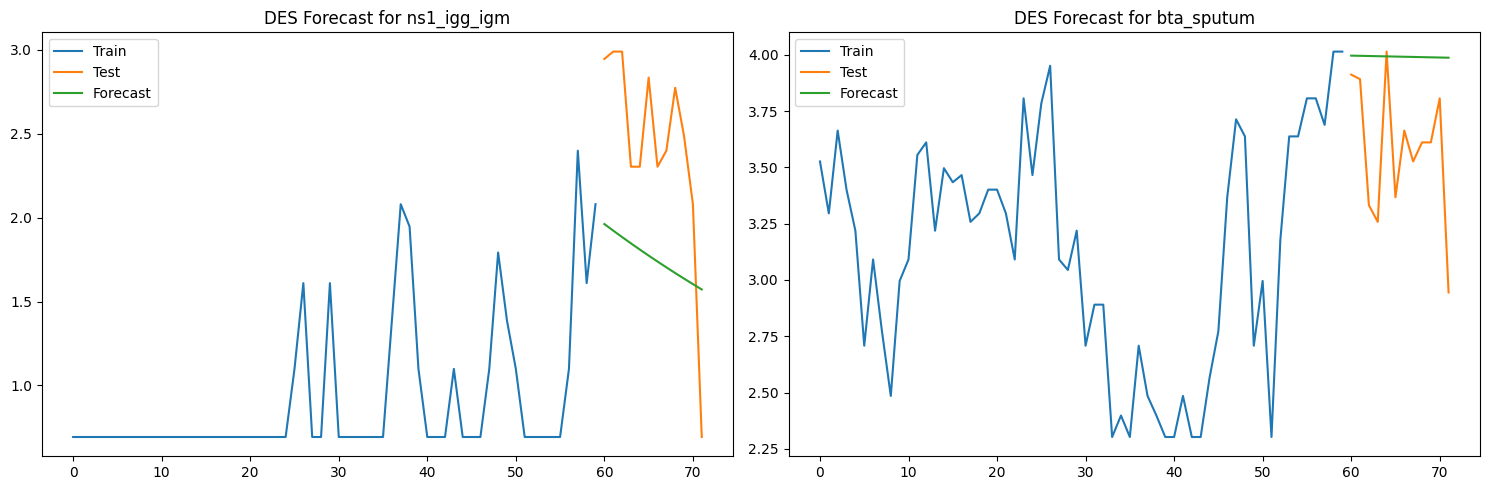

Fold: 6, Train: 72, Validation: 12
MAPE NS1:     Method                    Type  RMSE   MAPE   MAE   SMAPE
0  DES_MUL  ns1_igg_igm_log_capped  2.12  78.12  2.04  129.79, MAPE BTA:     Method                   Type  RMSE   MAPE   MAE  SMAPE
0  DES_MUL  bta_sputum_log_capped  0.57  13.05  0.48  14.18


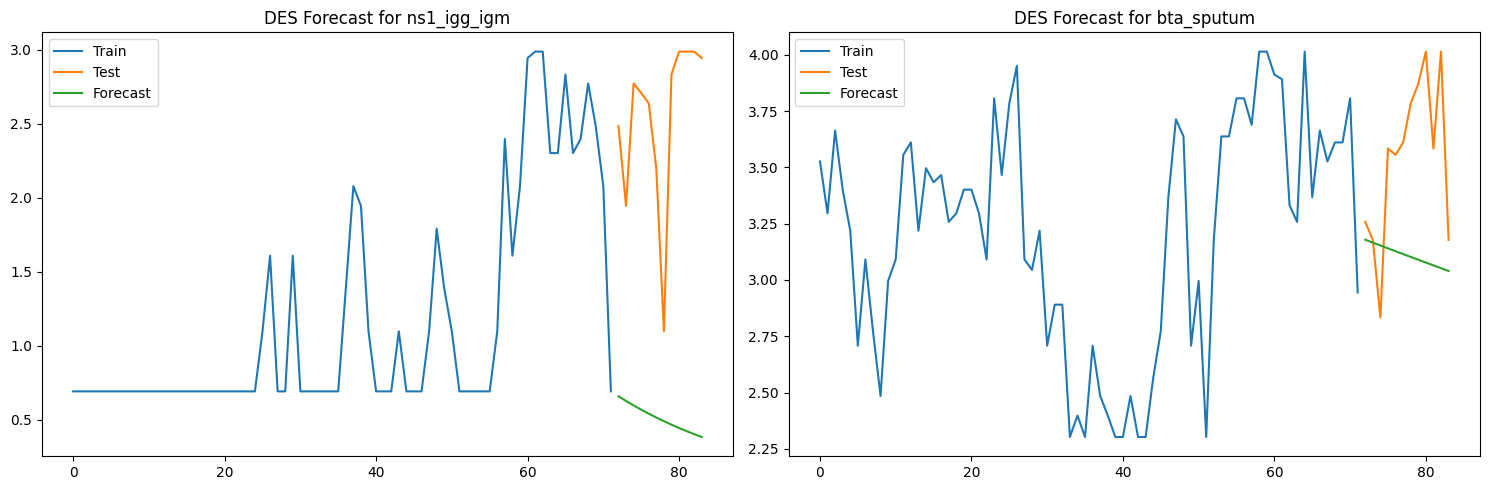

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.681335     1.435913e-15   
1  ns1_igg_igm_log_capped         1.000000     2.298437e-13   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0                 NaN            NaN       3.499409       0.995951   
1                 NaN            NaN       0.727961       0.952178   

  initial_seasons  use_boxcox lamda  remove_bias  
0              []       False  None        False  
1              []       False  None        False

In [33]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], trend='mul', seasonal=None)
    model2 = ExponentialSmoothing(train_split[LabelB], trend='mul', seasonal=None)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['DES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['DES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['DES_BTA'], 'DES_MUL', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['DES_NS1'], 'DES_MUL', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['DES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['DES_NS1']
    
    double_pred_mul = pd.concat([double_pred_mul, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    double_pred_mul = double_pred_mul.drop_duplicates(subset=['date'], keep='last')
    double_pred_mul = double_pred_mul.sort_values('date')
    double_pred_mul = double_pred_mul.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('DES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['DES_NS1'], LabelB, 'DES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['DES_BTA'], LabelA, 'DES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()
    
params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [34]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['DES_MUL', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['DES_MUL', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE      SMAPE
0    Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000  14.351667
1    Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667  37.953333
2  Average   bta_sputum_log_capped  0.500000  14.545000  0.440000  13.838333
3  Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000  54.600000
4      SES   bta_sputum_log_capped  0.505000  12.745000  0.388333  12.023333
5      SES  ns1_igg_igm_log_capped  0.696667  30.001667  0.581667  37.581667
6  DES_ADD   bta_sputum_log_capped  0.555000  14.386667  0.438333  13.875000
7  DES_ADD  ns1_igg_igm_log_capped  0.680000  30.683333  0.568333  36.883333
8  DES_MUL   bta_sputum_log_capped  1.258333  31.665000  1.028333  23.475000
9  DES_MUL  ns1_igg_igm_log_capped  0.773333  32.616667  0.661667  44.353333

In [35]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
double_pred_mul[cols_to_inverse] = double_pred_mul[cols_to_inverse].apply(np.expm1)
double_pred_mul.reset_index(drop=True, inplace=True)
double_pred_mul

date  predictions_BTA  predictions_NS1
0    12        42.893196         1.000000
1    13        65.281505         1.000000
2    14       103.687575         1.000000
3    15       172.792713         1.000000
4    16       303.901354         1.000000
..  ...              ...              ...
67   79        20.973120         0.597359
68   80        20.699950         0.561980
69   81        20.431261         0.529021
70   82        20.166967         0.498286
71   83        19.906983         0.469594

[72 rows x 3 columns]

## Triple Exponential Smoothing

### Triple Exp Smoothing Add+Add

In [36]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE  MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped   0.0   0.0  0.0    0.0, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  4.11  110.0  3.71  66.96


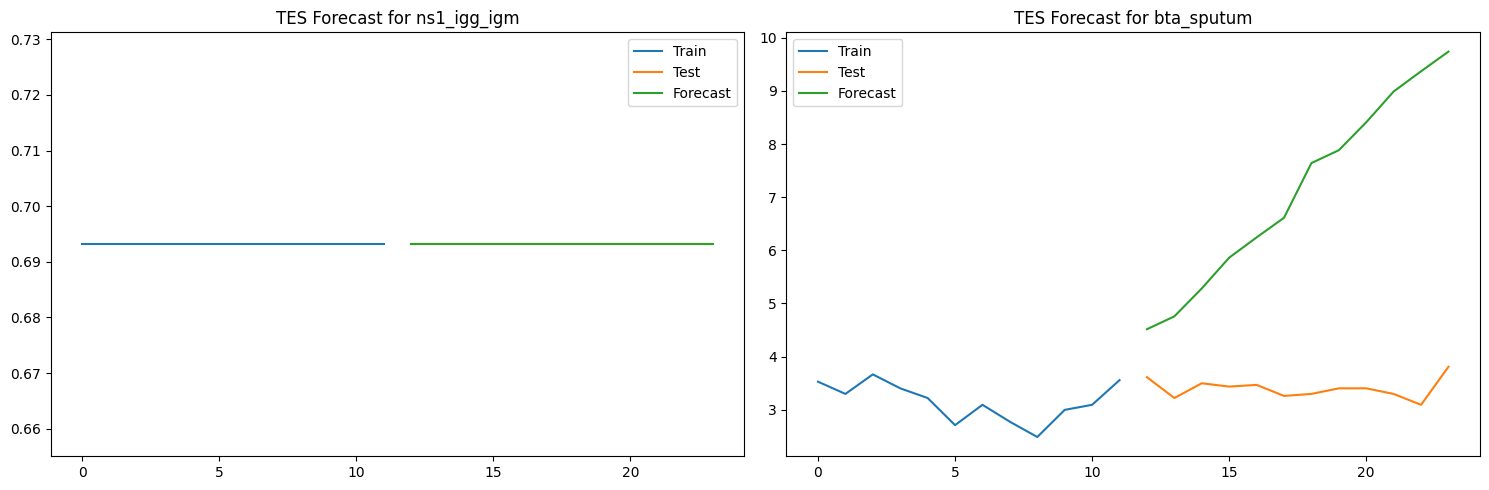

Fold: 2, Train: 24, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:         Method                   Type  RMSE  MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  0.86  28.3  0.76  23.64


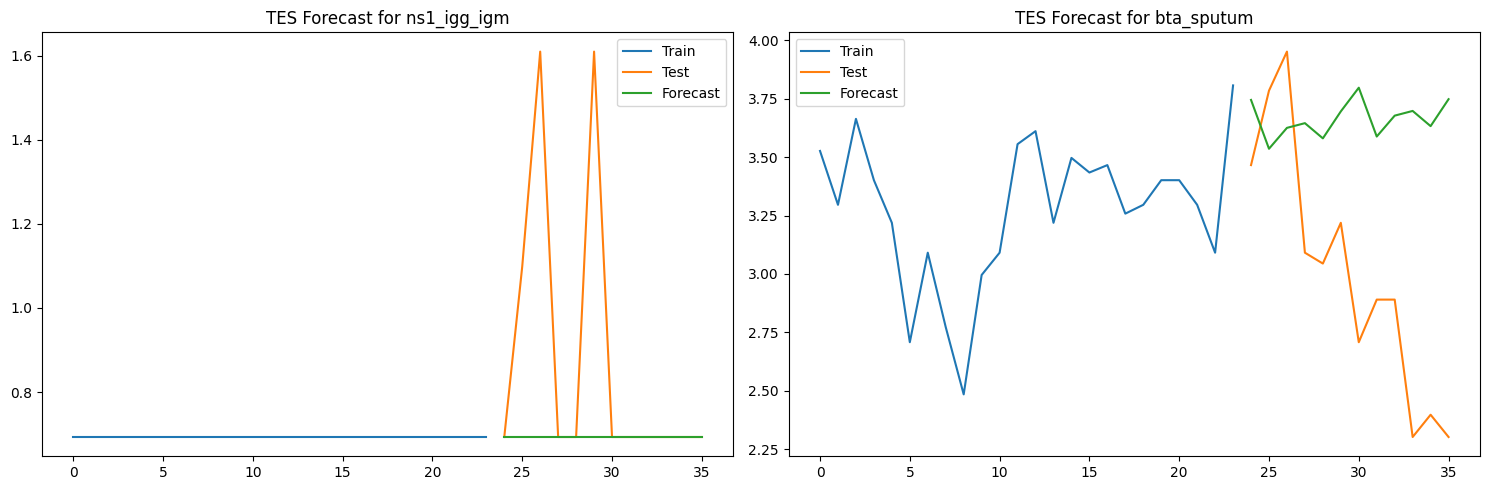

Fold: 3, Train: 36, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped  0.51  30.37  0.37  33.51, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  0.75  17.95  0.53  21.16


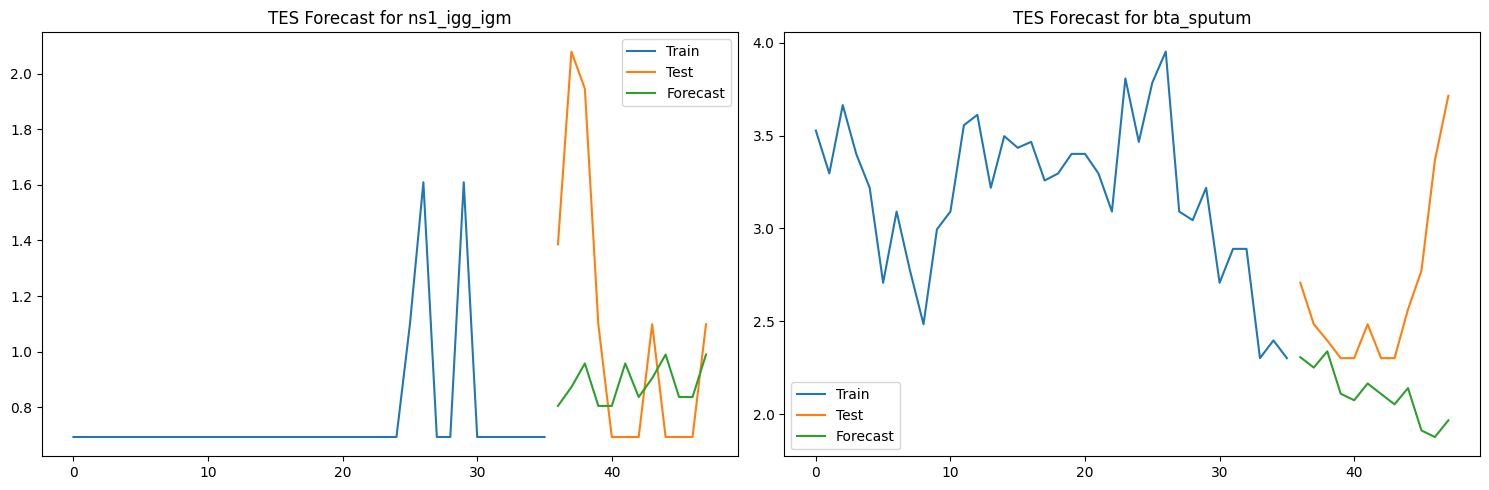

Fold: 4, Train: 48, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE  MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped  0.62  39.49  0.5  40.16, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  0.51  12.65  0.37  11.32


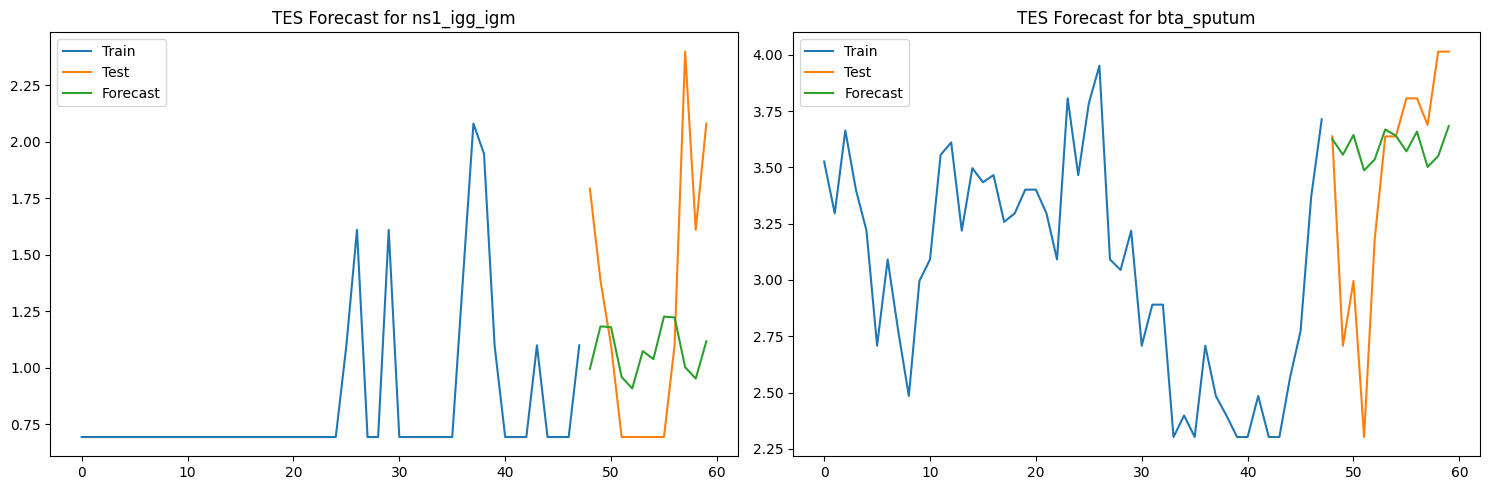

Fold: 5, Train: 60, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped  0.67  32.94  0.51  24.08, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  0.52  12.24  0.41  11.08


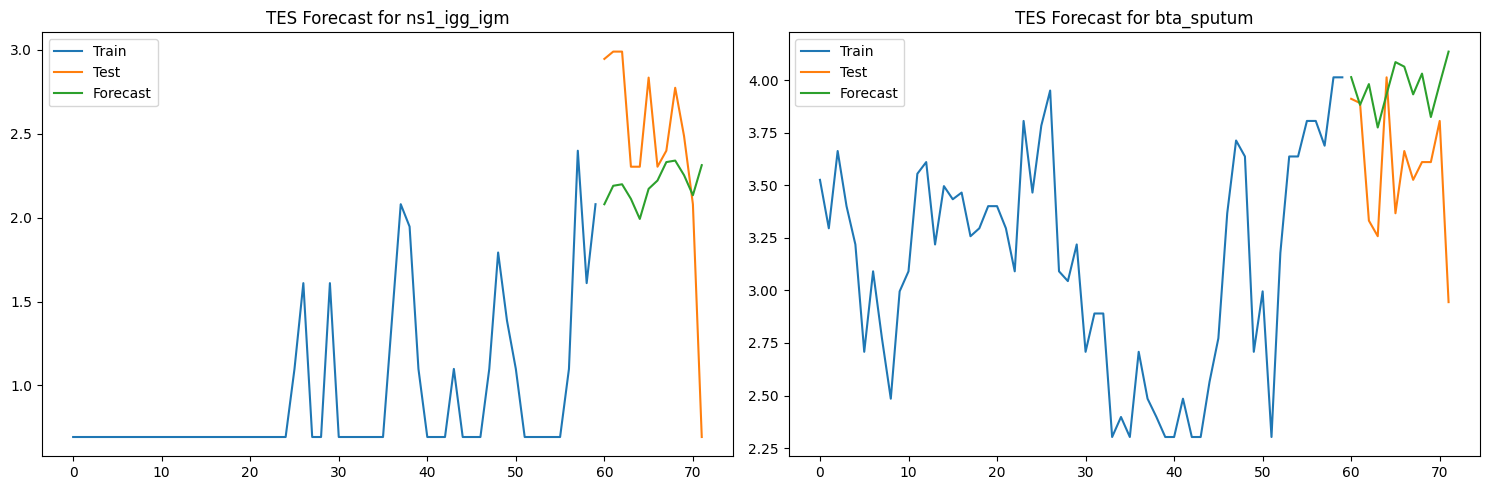

Fold: 6, Train: 72, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE   MAE  SMAPE
0  TES_ADD_ADD  ns1_igg_igm_log_capped  1.63  56.8  1.53  82.36, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_ADD  bta_sputum_log_capped  0.58  13.21  0.49   14.4


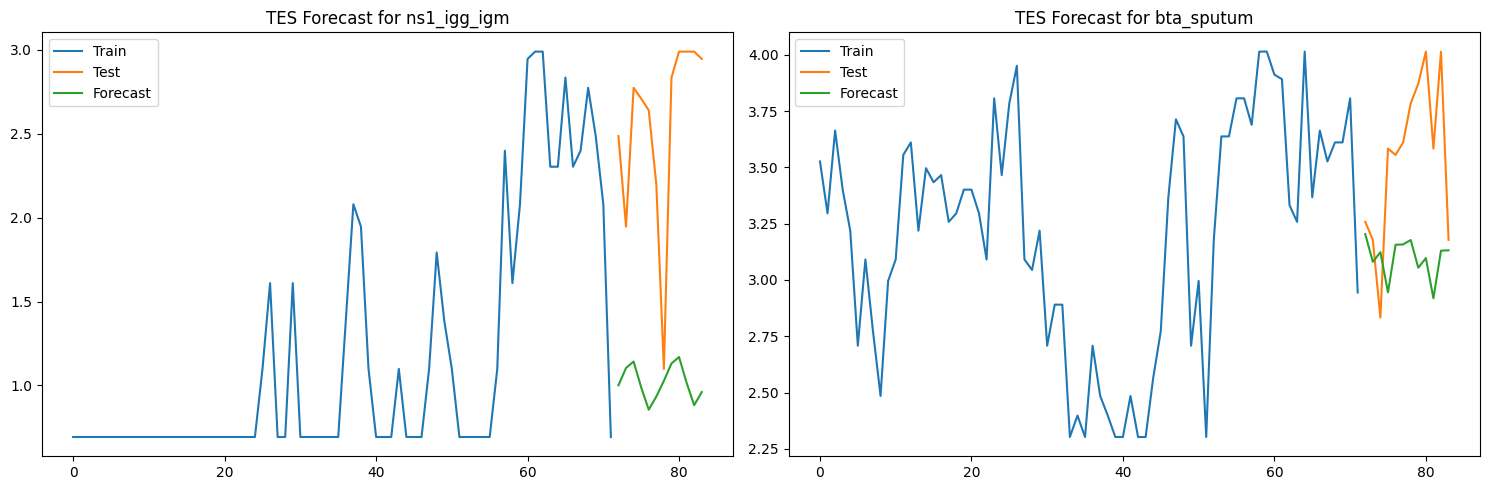

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.719064     1.546500e-12   
1  ns1_igg_igm_log_capped         0.857959     1.220132e-13   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0        0.000000e+00            NaN       3.380643      -0.004362   
1        3.726173e-15            NaN       0.669953       0.004489   

                                     initial_seasons  use_boxcox lamda  \
0  [0.14055817938432746, 0.0219353932171479, 0.06...       False  None   
1  [0.003816305929805289, 0.10246595791625572, 0....       False  None   

   remove_bias  
0        False  
1        False

In [37]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], trend='add', seasonal='add', seasonal_periods=6)
    model2 = ExponentialSmoothing(train_split[LabelB], trend='add', seasonal='add', seasonal_periods=6)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['TES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['TES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['TES_BTA'], 'TES_ADD_ADD', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['TES_NS1'], 'TES_ADD_ADD', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['TES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['TES_NS1']
    
    triple_pred_add_add = pd.concat([triple_pred_add_add, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    triple_pred_add_add = triple_pred_add_add.drop_duplicates(subset=['date'], keep='last')
    triple_pred_add_add = triple_pred_add_add.sort_values('date')
    triple_pred_add_add = triple_pred_add_add.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('TES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['TES_NS1'], LabelB, 'TES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['TES_BTA'], LabelA, 'TES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()

params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [38]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['TES_ADD_ADD', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['TES_ADD_ADD', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE  \
0         Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000   
1         Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667   
2       Average   bta_sputum_log_capped  0.500000  14.545000  0.440000   
3       Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000   
4           SES   bta_sputum_log_capped  0.505000  12.745000  0.388333   
5           SES  ns1_igg_igm_log_capped  0.696667  30.001667  0.581667   
6       DES_ADD   bta_sputum_log_capped  0.555000  14.386667  0.438333   
7       DES_ADD  ns1_igg_igm_log_capped  0.680000  30.683333  0.568333   
8       DES_MUL   bta_sputum_log_capped  1.258333  31.665000  1.028333   
9       DES_MUL  ns1_igg_igm_log_capped  0.773333  32.616667  0.661667   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667  32.391667  1.045000   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  0.636667  28.693333  0.516667   

        SMAPE  
0   14.351667  
1   37.953333  
2   13.838333  
3   54.600000  
4   12.023333  
5   37.581667  
6   13.875000  
7   36.883333  
8   23.475000  
9   44.353333  
10  24.760000  
11  32.858333

In [39]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
triple_pred_add_add[cols_to_inverse] = triple_pred_add_add[cols_to_inverse].apply(np.expm1)
triple_pred_add_add.reset_index(drop=True, inplace=True)
triple_pred_add_add

date  predictions_BTA  predictions_NS1
0    12        90.250450         1.000000
1    13       115.247133         1.000000
2    14       195.663576         1.000000
3    15       349.990211         1.000000
4    16       512.626635         1.000000
..  ...              ...              ...
67   79        20.209385         2.098393
68   80        21.134164         2.220656
69   81        17.518853         1.762149
70   82        21.876990         1.417496
71   83        21.914179         1.613659

[72 rows x 3 columns]

### Triple Exp Smoothing Mul+Add

In [40]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE  MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped   0.0   0.0  0.0    0.0, MAPE BTA:         Method                   Type  RMSE    MAPE   MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped   4.4  118.95  4.01  70.57


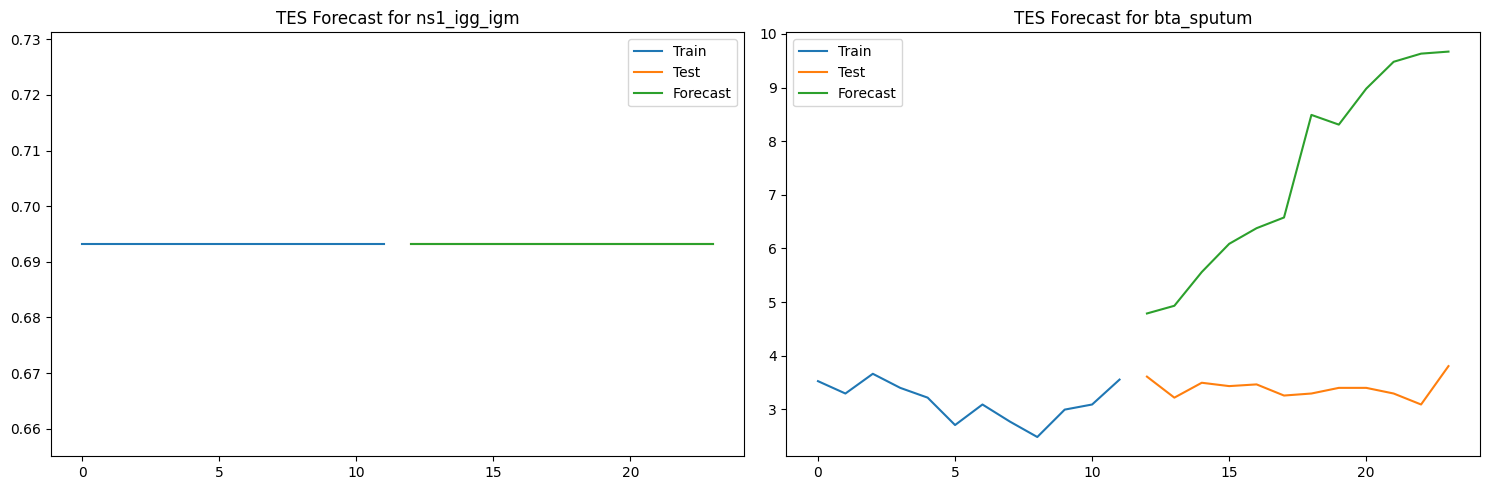

Fold: 2, Train: 24, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:         Method                   Type  RMSE  MAPE   MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped  0.87  28.6  0.76  23.84


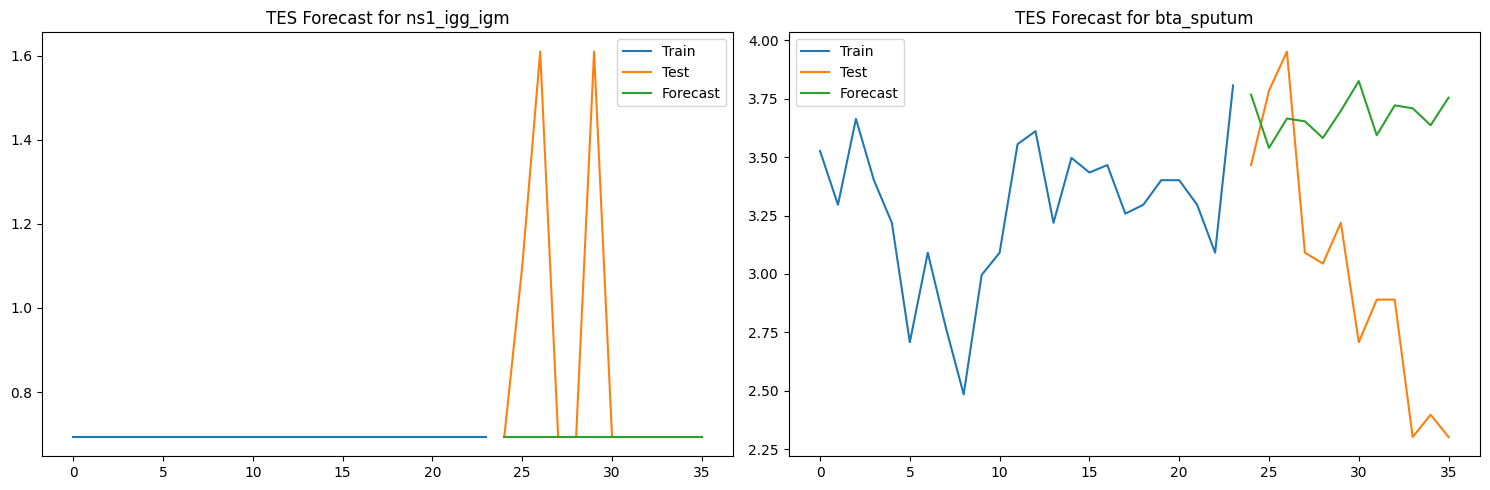

Fold: 3, Train: 36, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped  0.51  30.41  0.37  33.16, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped  0.74  17.83  0.53   21.0


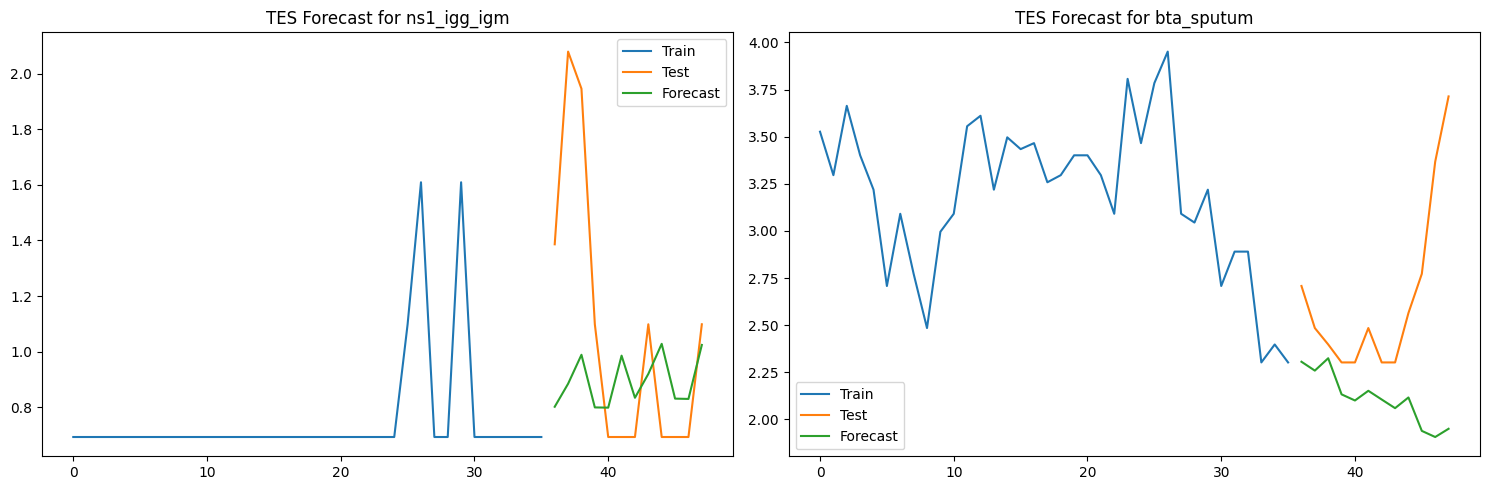

Fold: 4, Train: 48, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped  0.68  37.19  0.51   40.7, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped  0.51  12.65  0.37  11.37


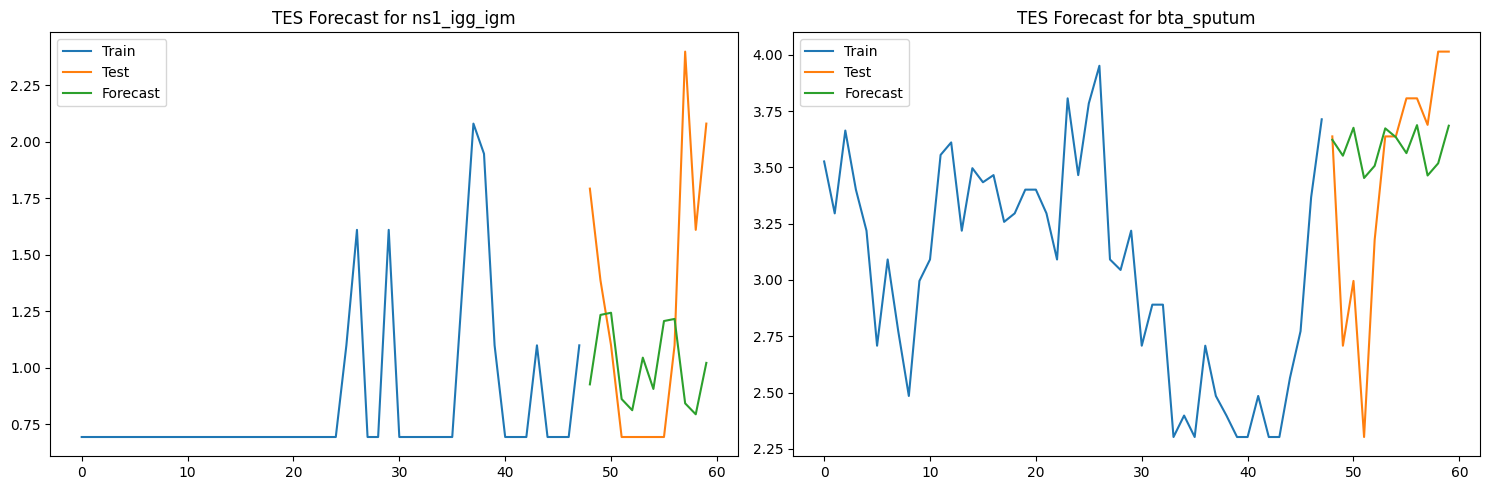

Fold: 5, Train: 60, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped  0.65  33.64  0.51   24.3, MAPE BTA:         Method                   Type  RMSE  MAPE  MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped  0.51  12.0  0.4  10.86


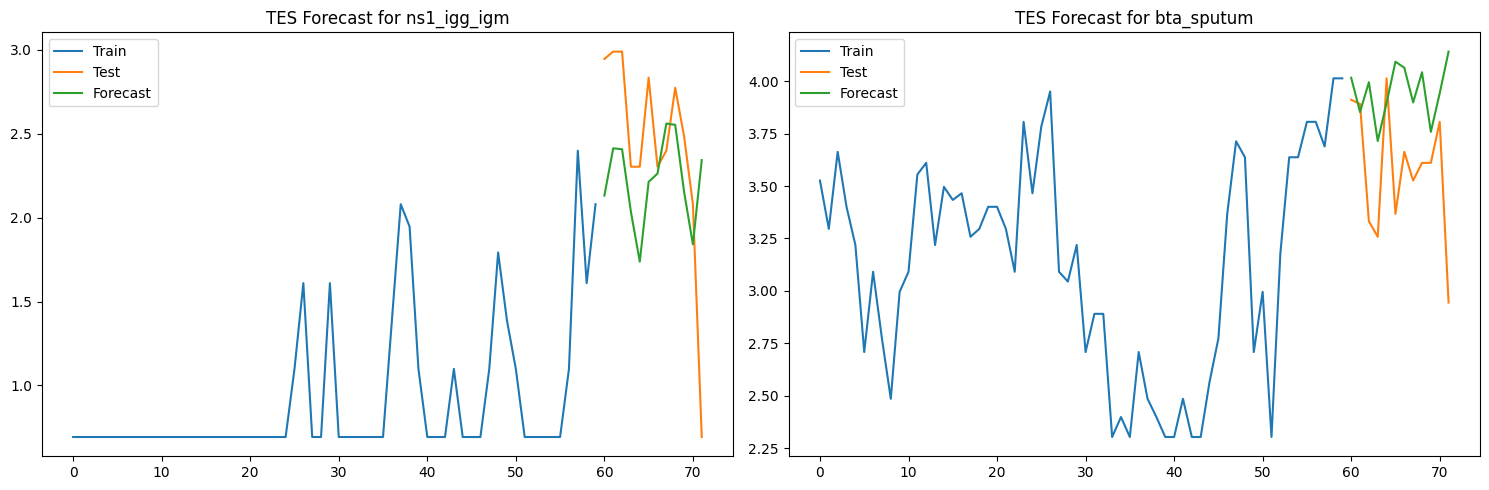

Fold: 6, Train: 72, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  ns1_igg_igm_log_capped  1.55  53.52  1.45  76.18, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_ADD  bta_sputum_log_capped  0.57  13.03  0.48  14.17


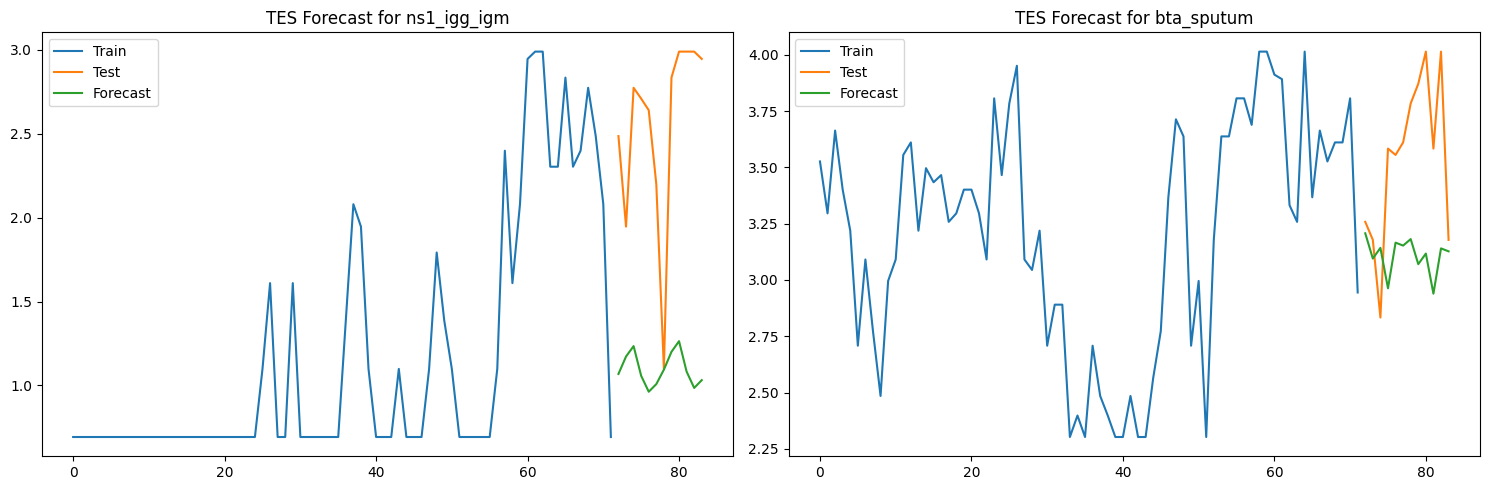

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.723088     1.294703e-13   
1  ns1_igg_igm_log_capped         0.807141     0.000000e+00   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0        2.749811e-13            NaN       3.085352      -0.003761   
1        0.000000e+00            NaN       0.648730       0.004113   

                                     initial_seasons  use_boxcox lamda  \
0  [1.1412610247626023, 1.1028350302427659, 1.121...       False  None   
1  [1.0383155682618193, 1.1345654669684988, 1.189...       False  None   

   remove_bias  
0        False  
1        False

In [41]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], seasonal='mul', trend='add', seasonal_periods=6)
    model2 = ExponentialSmoothing(train_split[LabelB], seasonal='mul', trend='add', seasonal_periods=6)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['TES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['TES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['TES_BTA'], 'TES_MUL_ADD', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['TES_NS1'], 'TES_MUL_ADD', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['TES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['TES_NS1']
    
    triple_pred_add_mul = pd.concat([triple_pred_add_mul, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    triple_pred_add_mul = triple_pred_add_mul.drop_duplicates(subset=['date'], keep='last')
    triple_pred_add_mul = triple_pred_add_mul.sort_values('date')
    triple_pred_add_mul = triple_pred_add_mul.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('TES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['TES_NS1'], LabelB, 'TES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['TES_BTA'], LabelA, 'TES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()

params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [42]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['TES_MUL_ADD', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['TES_MUL_ADD', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type      RMSE       MAPE       MAE  \
0         Naive   bta_sputum_log_capped  0.591667  15.290000  0.470000   
1         Naive  ns1_igg_igm_log_capped  0.703333  30.213333  0.581667   
2       Average   bta_sputum_log_capped  0.500000  14.545000  0.440000   
3       Average  ns1_igg_igm_log_capped  0.823333  64.193333  0.780000   
4           SES   bta_sputum_log_capped  0.505000  12.745000  0.388333   
5           SES  ns1_igg_igm_log_capped  0.696667  30.001667  0.581667   
6       DES_ADD   bta_sputum_log_capped  0.555000  14.386667  0.438333   
7       DES_ADD  ns1_igg_igm_log_capped  0.680000  30.683333  0.568333   
8       DES_MUL   bta_sputum_log_capped  1.258333  31.665000  1.028333   
9       DES_MUL  ns1_igg_igm_log_capped  0.773333  32.616667  0.661667   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667  32.391667  1.045000   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  0.636667  28.693333  0.516667   
12  TES_MUL_ADD   bta_sputum_log_capped  1.266667  33.843333  1.091667   
13  TES_MUL_ADD  ns1_igg_igm_log_capped  0.630000  27.886667  0.505000   

        SMAPE  
0   14.351667  
1   37.953333  
2   13.838333  
3   54.600000  
4   12.023333  
5   37.581667  
6   13.875000  
7   36.883333  
8   23.475000  
9   44.353333  
10  24.760000  
11  32.858333  
12  25.301667  
13  31.896667

In [43]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
triple_pred_add_mul[cols_to_inverse] = triple_pred_add_mul[cols_to_inverse].apply(np.expm1)
triple_pred_add_mul.reset_index(drop=True, inplace=True)
triple_pred_add_mul

date  predictions_BTA  predictions_NS1
0    12       119.085822         1.000000
1    13       137.602288         1.000000
2    14       259.107064         1.000000
3    15       439.038241         1.000000
4    16       588.062111         1.000000
..  ...              ...              ...
67   79        20.547602         2.321229
68   80        21.584539         2.538815
69   81        17.897147         1.952587
70   82        22.109981         1.678860
71   83        21.810915         1.806229

[72 rows x 3 columns]

In [44]:
triple_pred_add_mul.to_excel("triple_pred_add_mul_2024.xlsx")
with pd.ExcelWriter("D:\\KINANTHI\\KULIAH\\TA\\data_new\\triple_pred_add_mul_2024.xlsx", date_format='yyyy-mm-dd') as writer:
   triple_pred_add_mul.to_excel(writer, index=False)

### Triple Exp Smoothing Add+Mul

In [45]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE  MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped   0.0  0.04  0.0   0.04, MAPE BTA:         Method                   Type         RMSE          MAPE          MAE  \
0  TES_ADD_MUL  bta_sputum_log_capped  50812761.35  4.973991e+08  18125270.05   

    SMAPE  
0  185.56  


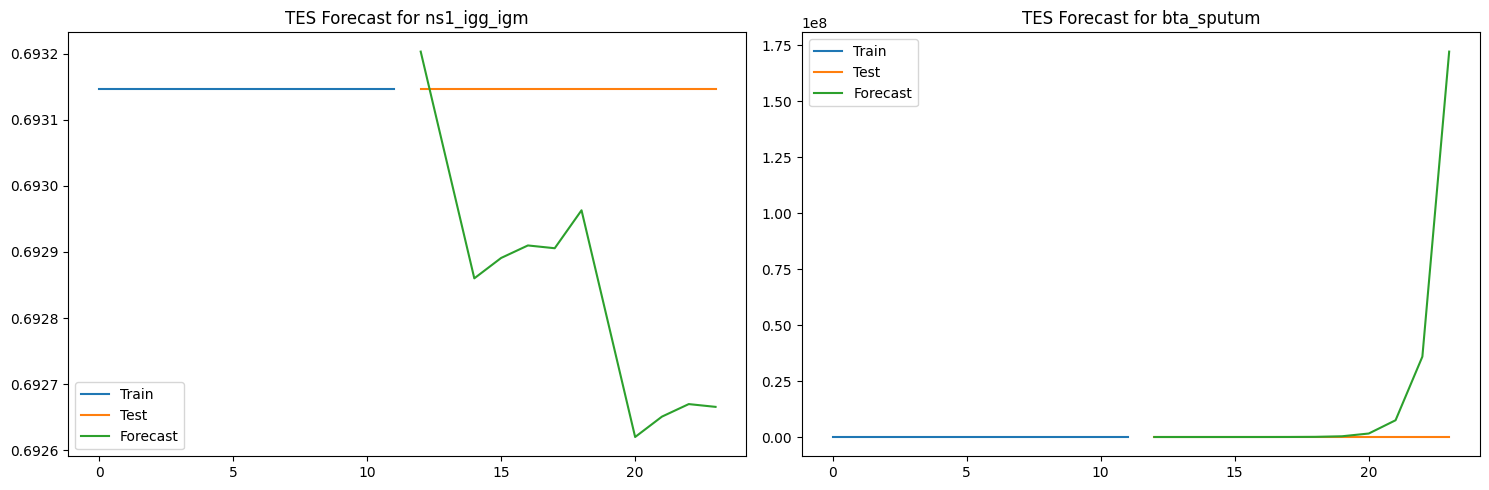

Fold: 2, Train: 24, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:         Method                   Type  RMSE  MAPE   MAE  SMAPE
0  TES_ADD_MUL  bta_sputum_log_capped  0.82  27.0  0.72  22.76


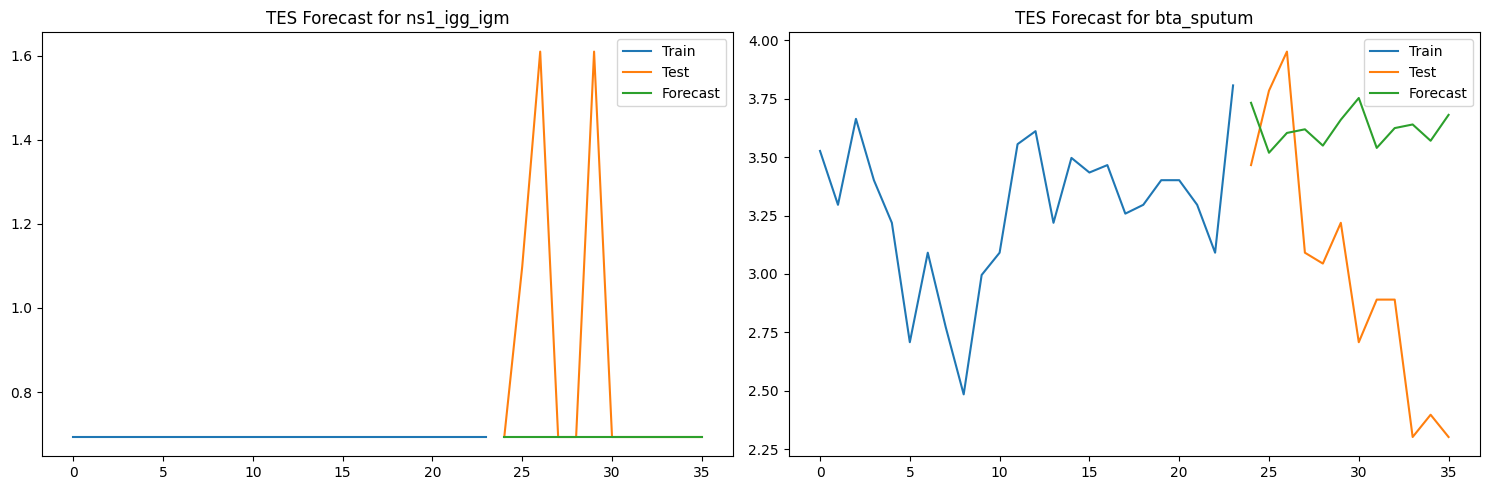

Fold: 3, Train: 36, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped  0.51  30.75  0.37  33.68, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  bta_sputum_log_capped  0.41  12.72  0.34  12.52


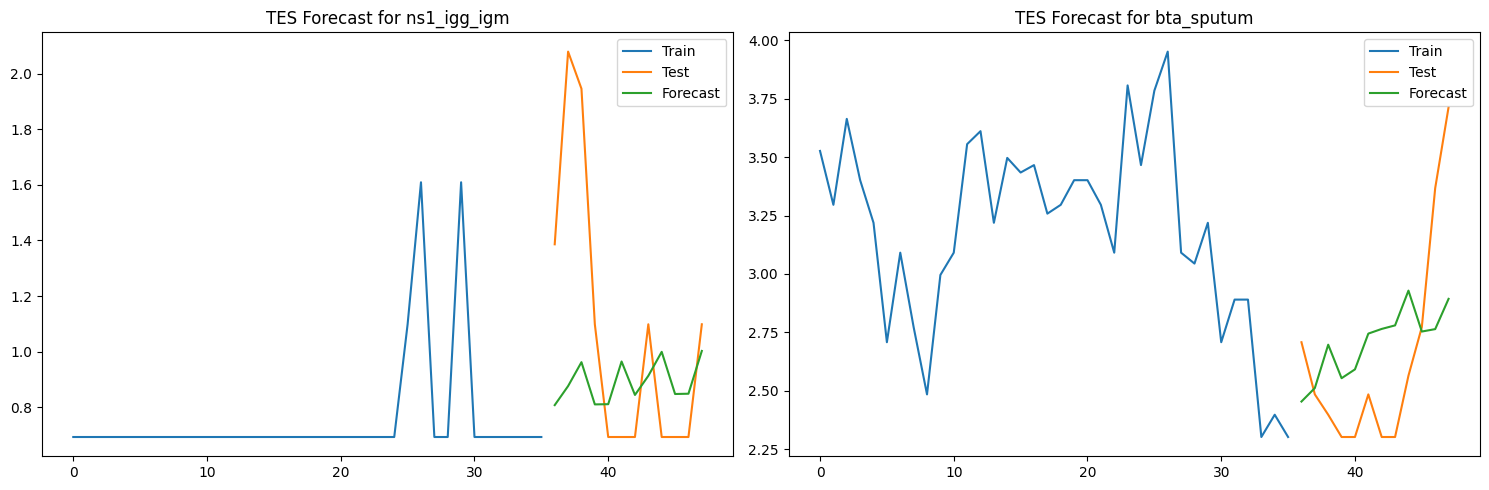

Fold: 4, Train: 48, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped  0.61  43.63  0.52  41.95, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  bta_sputum_log_capped  0.51  13.01  0.39   11.8


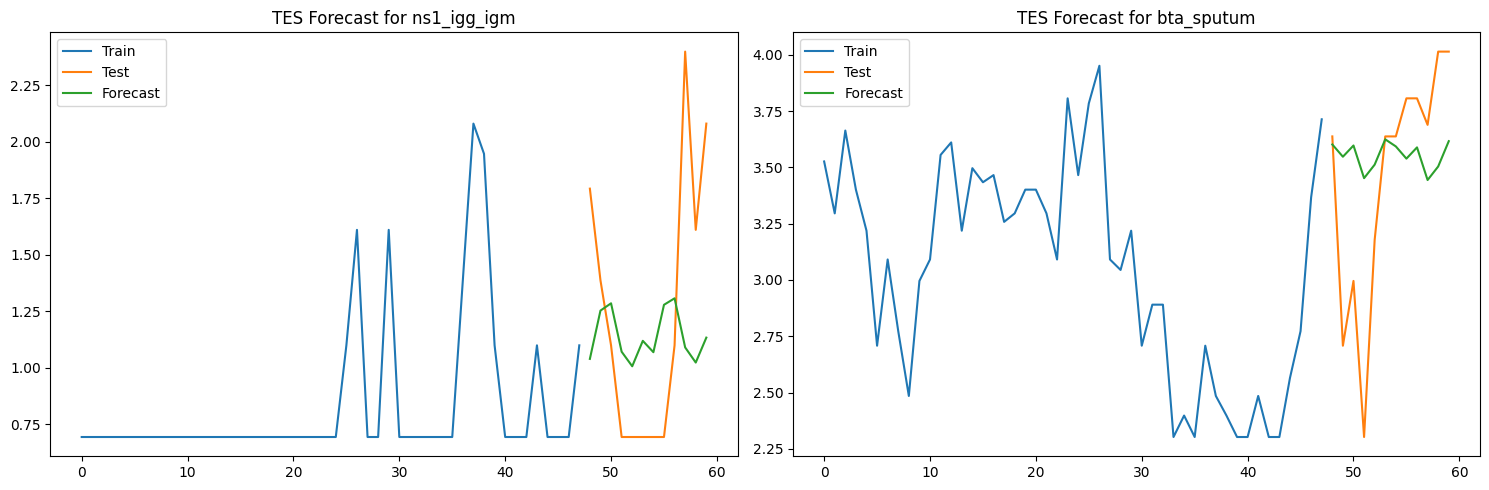

Fold: 5, Train: 60, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE  MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped  0.92  40.83  0.9  45.36, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  bta_sputum_log_capped  0.46  10.67  0.35   9.74


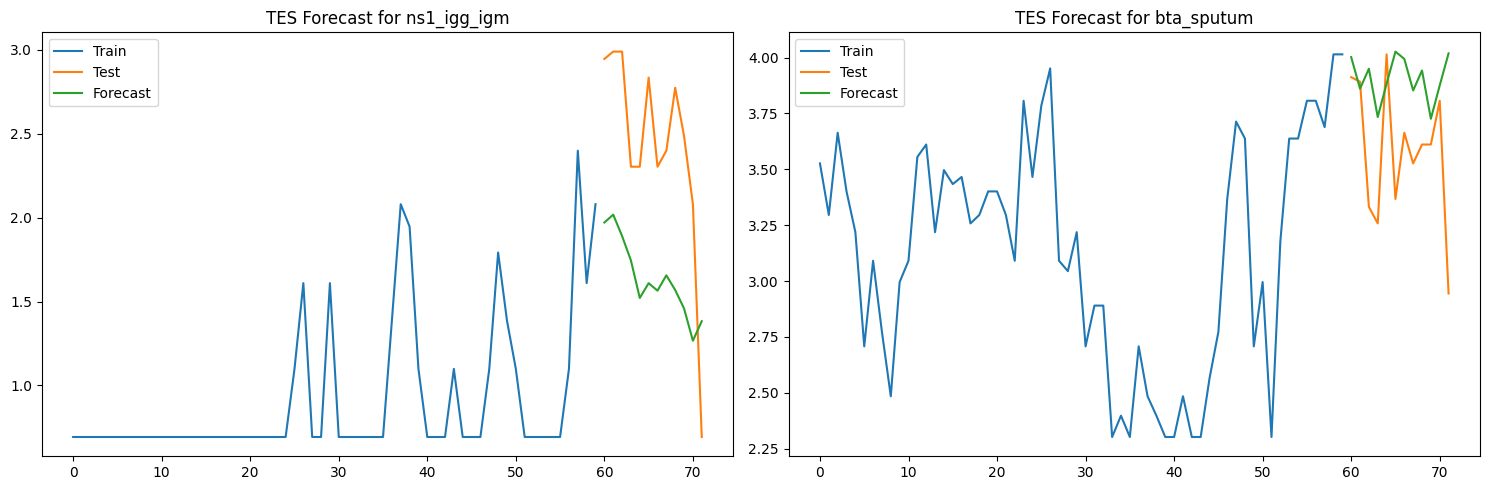

Fold: 6, Train: 72, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_ADD_MUL  ns1_igg_igm_log_capped  1.77  63.71  1.69  95.94, MAPE BTA:         Method                   Type  RMSE  MAPE   MAE  SMAPE
0  TES_ADD_MUL  bta_sputum_log_capped  0.49  11.3  0.42  12.07


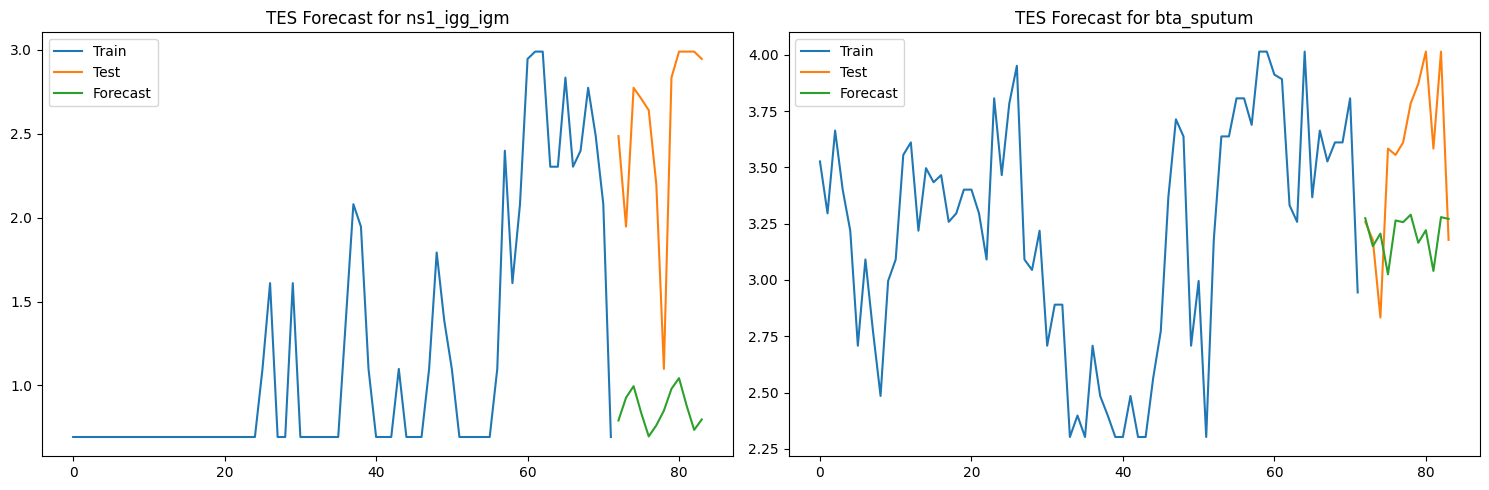

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.644797         0.000000   
1  ns1_igg_igm_log_capped         0.996560         0.000151   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0            0.000000            NaN   4.669598e-11       0.985939   
1            0.000614            NaN   6.106188e-03       0.569107   

                                     initial_seasons  use_boxcox lamda  \
0  [3.466178922131592, 3.3389259994289335, 3.3924...       False  None   
1  [0.9189038898558043, 1.0422533450017049, 1.099...       False  None   

   remove_bias  
0        False  
1        False

In [46]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], seasonal='add', trend='mul', seasonal_periods=6)
    model2 = ExponentialSmoothing(train_split[LabelB], seasonal='add', trend='mul', seasonal_periods=6)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['TES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['TES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['TES_BTA'], 'TES_ADD_MUL', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['TES_NS1'], 'TES_ADD_MUL', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['TES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['TES_NS1']
    
    triple_pred_mul_add = pd.concat([triple_pred_mul_add, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    triple_pred_mul_add = triple_pred_mul_add.drop_duplicates(subset=['date'], keep='last')
    triple_pred_mul_add = triple_pred_mul_add.sort_values('date')
    triple_pred_mul_add = triple_pred_mul_add.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('TES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['TES_NS1'], LabelB, 'TES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['TES_BTA'], LabelA, 'TES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()

params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [47]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['TES_ADD_MUL', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['TES_ADD_MUL', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type          RMSE          MAPE  \
0         Naive   bta_sputum_log_capped  5.916667e-01  1.529000e+01   
1         Naive  ns1_igg_igm_log_capped  7.033333e-01  3.021333e+01   
2       Average   bta_sputum_log_capped  5.000000e-01  1.454500e+01   
3       Average  ns1_igg_igm_log_capped  8.233333e-01  6.419333e+01   
4           SES   bta_sputum_log_capped  5.050000e-01  1.274500e+01   
5           SES  ns1_igg_igm_log_capped  6.966667e-01  3.000167e+01   
6       DES_ADD   bta_sputum_log_capped  5.550000e-01  1.438667e+01   
7       DES_ADD  ns1_igg_igm_log_capped  6.800000e-01  3.068333e+01   
8       DES_MUL   bta_sputum_log_capped  1.258333e+00  3.166500e+01   
9       DES_MUL  ns1_igg_igm_log_capped  7.733333e-01  3.261667e+01   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667e+00  3.239167e+01   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  6.366667e-01  2.869333e+01   
12  TES_MUL_ADD   bta_sputum_log_capped  1.266667e+00  3.384333e+01   
13  TES_MUL_ADD  ns1_igg_igm_log_capped  6.300000e-01  2.788667e+01   
14  TES_ADD_MUL   bta_sputum_log_capped  8.468794e+06  8.289986e+07   
15  TES_ADD_MUL  ns1_igg_igm_log_capped  7.000000e-01  3.192000e+01   

             MAE      SMAPE  
0   4.700000e-01  14.351667  
1   5.816667e-01  37.953333  
2   4.400000e-01  13.838333  
3   7.800000e-01  54.600000  
4   3.883333e-01  12.023333  
5   5.816667e-01  37.581667  
6   4.383333e-01  13.875000  
7   5.683333e-01  36.883333  
8   1.028333e+00  23.475000  
9   6.616667e-01  44.353333  
10  1.045000e+00  24.760000  
11  5.166667e-01  32.858333  
12  1.091667e+00  25.301667  
13  5.050000e-01  31.896667  
14  3.020879e+06  42.408333  
15  6.116667e-01  39.001667

In [48]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
triple_pred_mul_add[cols_to_inverse] = triple_pred_mul_add[cols_to_inverse].apply(np.expm1)
triple_pred_mul_add.reset_index(drop=True, inplace=True)
triple_pred_mul_add

date  predictions_BTA  predictions_NS1
0    12     4.311808e+03         1.000112
1    13     5.529228e+12         0.999769
2    14     7.566647e+56         0.999426
3    15    2.368592e+268         0.999487
4    16              inf         0.999525
..  ...              ...              ...
67   79     2.269330e+01         1.664604
68   80     2.405725e+01         1.839661
69   81     1.990807e+01         1.411996
70   82     2.555296e+01         1.086635
71   83     2.534471e+01         1.220321

[72 rows x 3 columns]

### Triple Exp Smoothing Mul+Mul

In [49]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

Fold: 1, Train: 12, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE  MAE  SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped   0.0  0.03  0.0   0.03, MAPE BTA:         Method                   Type   RMSE   MAPE    MAE   SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  12.69  303.9  10.28  103.95


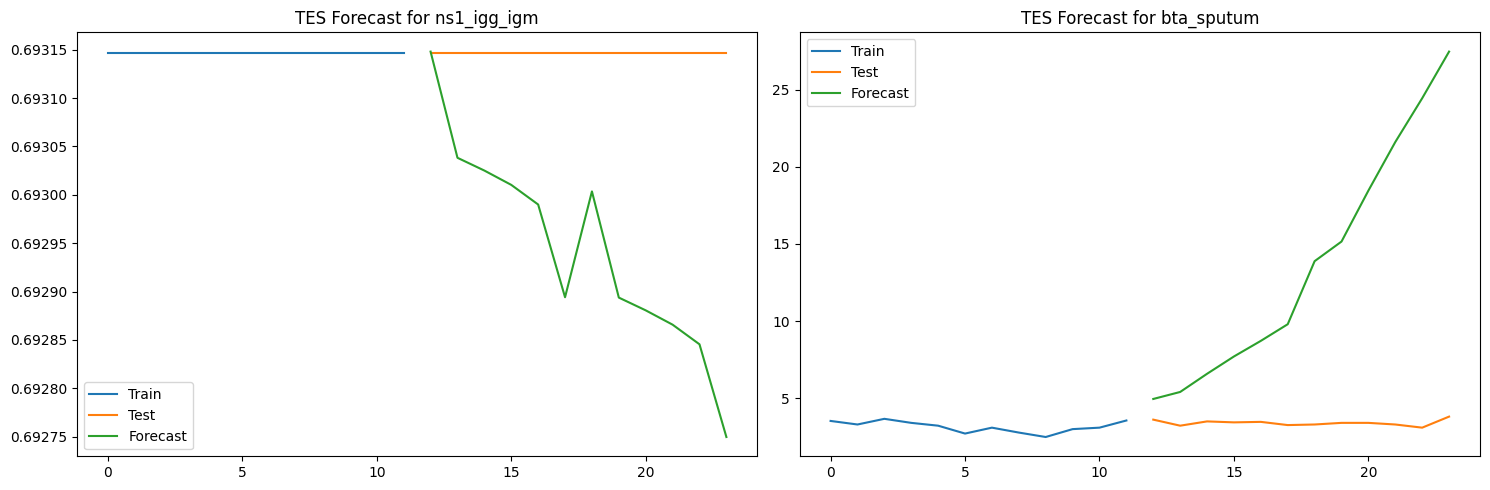

Fold: 2, Train: 24, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped  0.39  12.56  0.19  17.04, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  0.83  27.37  0.73   23.0


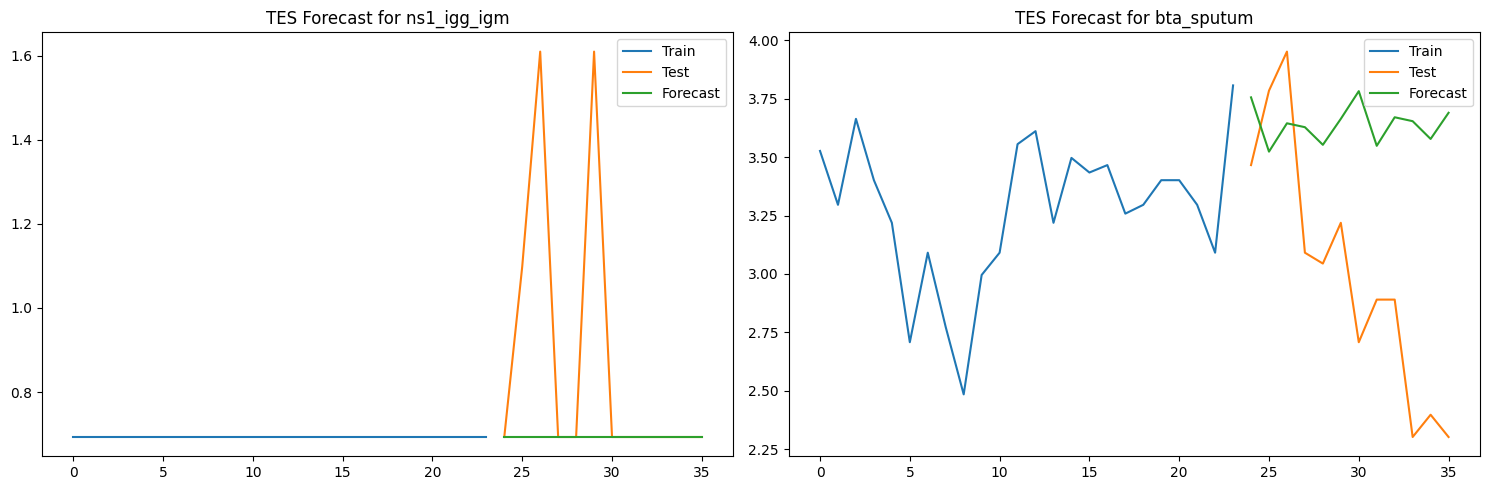

Fold: 3, Train: 36, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped  0.51  30.81  0.37  33.33, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  0.69  15.77  0.47   18.4


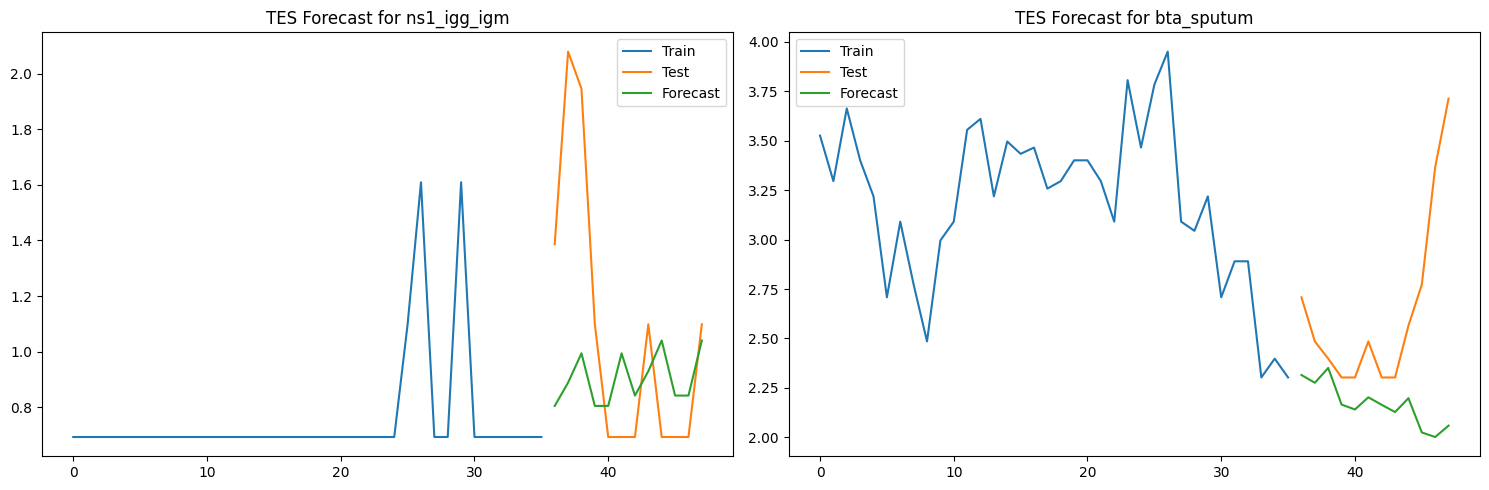

Fold: 4, Train: 48, Validation: 12
MAPE NS1:         Method                    Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped  0.77  30.77  0.51  40.48, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  0.52  13.49  0.41  12.42


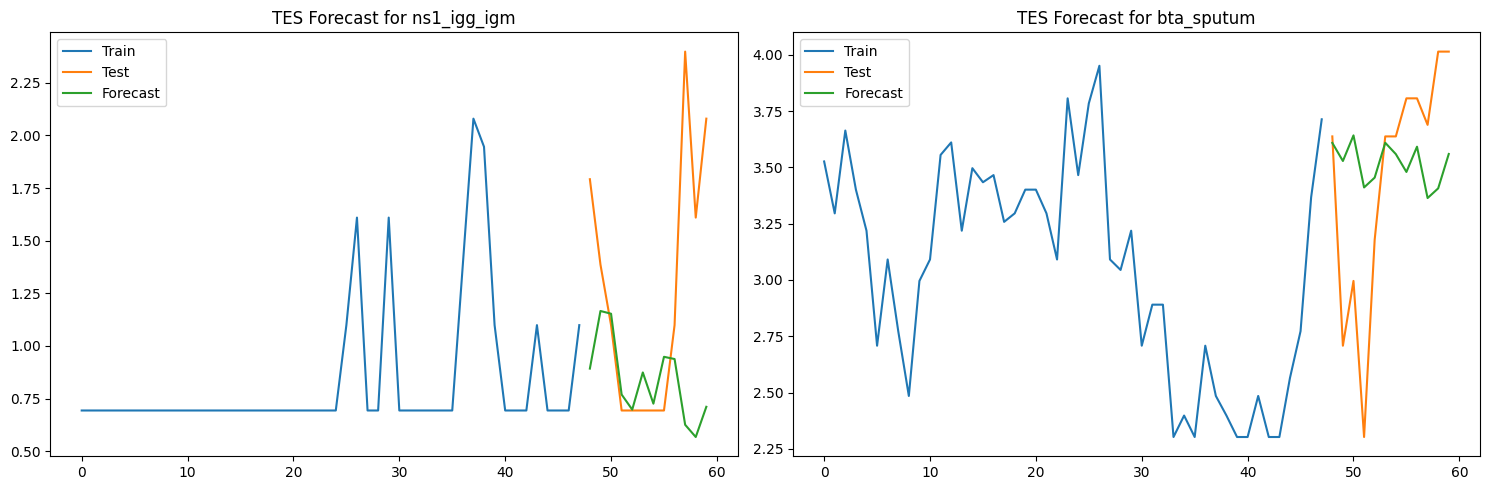

Fold: 5, Train: 60, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE   MAE  SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped  0.74  36.7  0.72   35.5, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  0.46  10.44  0.35   9.53


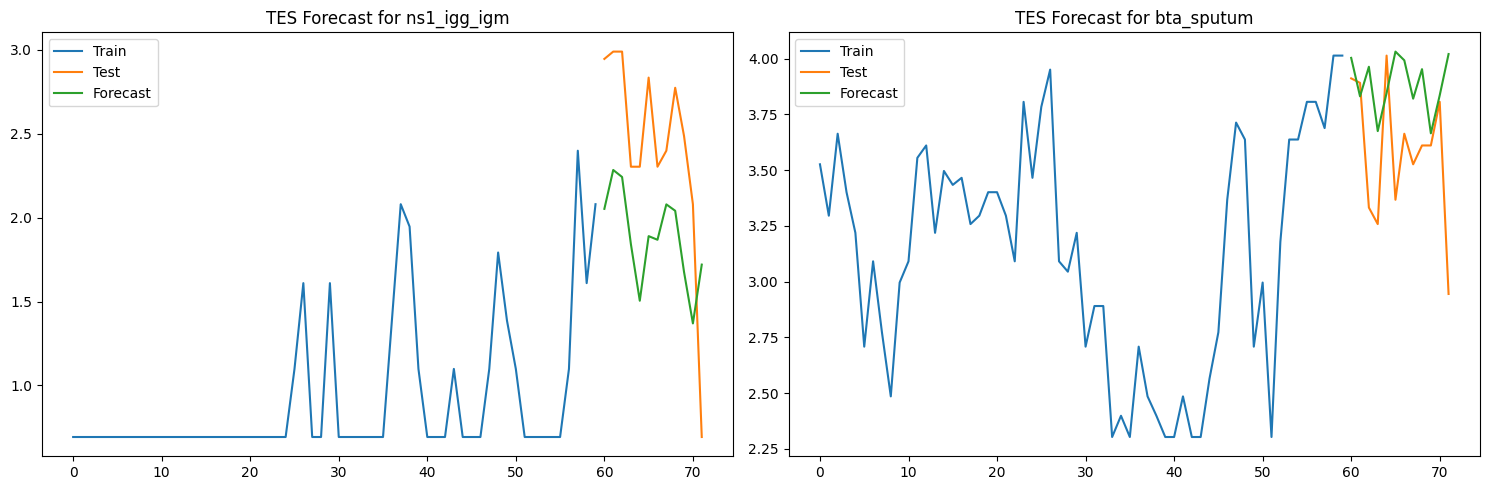

Fold: 6, Train: 72, Validation: 12
MAPE NS1:         Method                    Type  RMSE  MAPE   MAE   SMAPE
0  TES_MUL_MUL  ns1_igg_igm_log_capped   1.9  68.3  1.81  106.22, MAPE BTA:         Method                   Type  RMSE   MAPE   MAE  SMAPE
0  TES_MUL_MUL  bta_sputum_log_capped  0.63  14.61  0.54  16.05


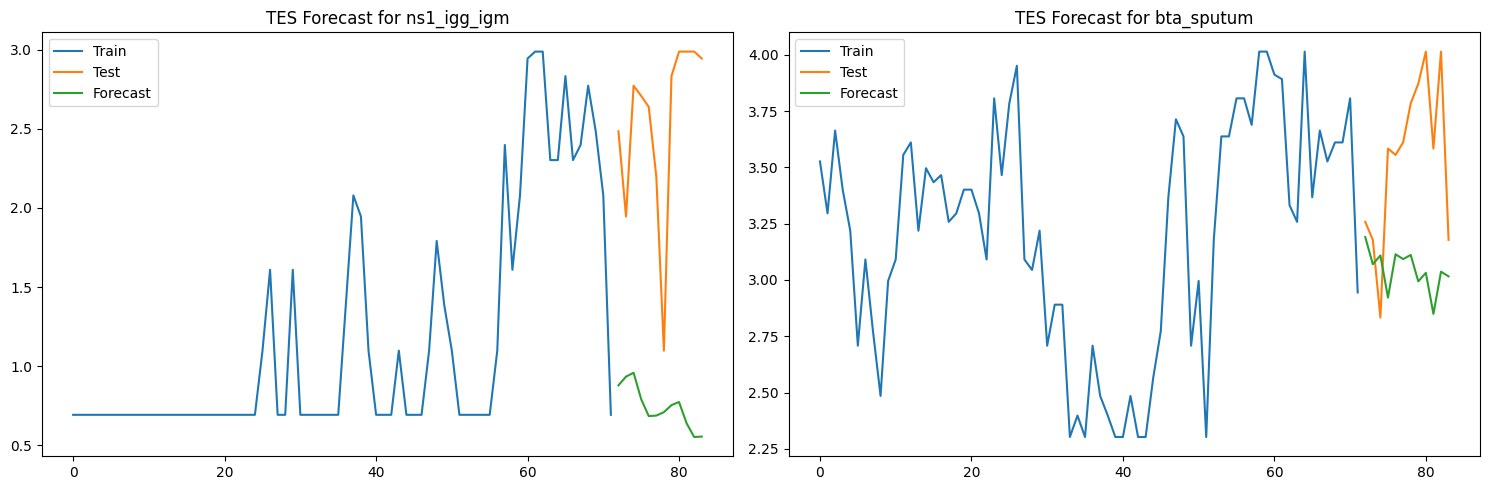

Label  smoothing_level  smoothing_trend  \
0   bta_sputum_log_capped         0.726301     8.541881e-14   
1  ns1_igg_igm_log_capped         0.886091     0.000000e+00   

   smoothing_seasonal  damping_trend  initial_level  initial_trend  \
0                 0.0            NaN       3.024470       0.995821   
1                 0.0            NaN       0.660674       0.964929   

                                     initial_seasons  use_boxcox lamda  \
0  [1.1689237266803487, 1.129574567163451, 1.1486...       False  None   
1  [1.0789145399788629, 1.1881987336667694, 1.263...       False  None   

   remove_bias  
0        False  
1        False

In [50]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ExponentialSmoothing(train_split[LabelA], seasonal='mul', trend='mul', seasonal_periods=6)
    model2 = ExponentialSmoothing(train_split[LabelB], seasonal='mul', trend='mul', seasonal_periods=6)
    
    model_fit1 = model1.fit(optimized=True)
    model_fit2 = model2.fit(optimized=True)
    
    y_hat_holt = val_split.copy()
    y_hat_holt['TES_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_holt['TES_NS1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_holt['TES_BTA'], 'TES_MUL_MUL', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_holt['TES_NS1'], 'TES_MUL_MUL', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_holt['date'] = val_split.index
    y_hat_holt['predictions_BTA'] = y_hat_holt['TES_BTA']
    y_hat_holt['predictions_NS1'] = y_hat_holt['TES_NS1']
    
    triple_pred_mul_mul = pd.concat([triple_pred_mul_mul, y_hat_holt[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    triple_pred_mul_mul = triple_pred_mul_mul.drop_duplicates(subset=['date'], keep='last')
    triple_pred_mul_mul = triple_pred_mul_mul.sort_values('date')
    triple_pred_mul_mul = triple_pred_mul_mul.reset_index(drop=True)
    
    print(f"Fold: {int(len(train_split)/len(val_split))}, Train: {len(train_split)}, Validation: {len(val_split)}\nMAPE NS1: {eval_ns1}, MAPE BTA: {eval_bta}")
    plt.figure(figsize=(15,5))
    # plt.title('TES Forecasting')
    plt.subplot(1, 2, 1)
    plot_forecast(train_split[LabelB], val_split[LabelB], y_hat_holt['TES_NS1'], LabelB, 'TES Forecast for ns1_igg_igm', transform=np.expm1)
    plt.subplot(1, 2, 2)
    plot_forecast(train_split[LabelA], val_split[LabelA], y_hat_holt['TES_BTA'], LabelA, 'TES Forecast for bta_sputum', transform=np.expm1)
    plt.tight_layout()
    plt.show()
    
params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

In [51]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['TES_MUL_MUL', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['TES_MUL_MUL', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type          RMSE          MAPE  \
0         Naive   bta_sputum_log_capped  5.916667e-01  1.529000e+01   
1         Naive  ns1_igg_igm_log_capped  7.033333e-01  3.021333e+01   
2       Average   bta_sputum_log_capped  5.000000e-01  1.454500e+01   
3       Average  ns1_igg_igm_log_capped  8.233333e-01  6.419333e+01   
4           SES   bta_sputum_log_capped  5.050000e-01  1.274500e+01   
5           SES  ns1_igg_igm_log_capped  6.966667e-01  3.000167e+01   
6       DES_ADD   bta_sputum_log_capped  5.550000e-01  1.438667e+01   
7       DES_ADD  ns1_igg_igm_log_capped  6.800000e-01  3.068333e+01   
8       DES_MUL   bta_sputum_log_capped  1.258333e+00  3.166500e+01   
9       DES_MUL  ns1_igg_igm_log_capped  7.733333e-01  3.261667e+01   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667e+00  3.239167e+01   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  6.366667e-01  2.869333e+01   
12  TES_MUL_ADD   bta_sputum_log_capped  1.266667e+00  3.384333e+01   
13  TES_MUL_ADD  ns1_igg_igm_log_capped  6.300000e-01  2.788667e+01   
14  TES_ADD_MUL   bta_sputum_log_capped  8.468794e+06  8.289986e+07   
15  TES_ADD_MUL  ns1_igg_igm_log_capped  7.000000e-01  3.192000e+01   
16  TES_MUL_MUL   bta_sputum_log_capped  2.636667e+00  6.426333e+01   
17  TES_MUL_MUL  ns1_igg_igm_log_capped  7.183333e-01  2.986167e+01   

             MAE      SMAPE  
0   4.700000e-01  14.351667  
1   5.816667e-01  37.953333  
2   4.400000e-01  13.838333  
3   7.800000e-01  54.600000  
4   3.883333e-01  12.023333  
5   5.816667e-01  37.581667  
6   4.383333e-01  13.875000  
7   5.683333e-01  36.883333  
8   1.028333e+00  23.475000  
9   6.616667e-01  44.353333  
10  1.045000e+00  24.760000  
11  5.166667e-01  32.858333  
12  1.091667e+00  25.301667  
13  5.050000e-01  31.896667  
14  3.020879e+06  42.408333  
15  6.116667e-01  39.001667  
16  2.130000e+00  30.558333  
17  6.000000e-01  38.766667

In [52]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
triple_pred_mul_mul[cols_to_inverse] = triple_pred_mul_mul[cols_to_inverse].apply(np.expm1)
triple_pred_mul_mul.reset_index(drop=True, inplace=True)
triple_pred_mul_mul

date  predictions_BTA  predictions_NS1
0    12       140.270860         1.000002
1    13       221.368867         0.999782
2    14       721.264774         0.999756
3    15      2217.914310         0.999726
4    16      6102.864210         0.999686
..  ...              ...              ...
67   79        18.963676         1.126187
68   80        19.731736         1.168535
69   81        16.274368         0.895336
70   82        19.838107         0.738326
71   83        19.409127         0.743117

[72 rows x 3 columns]

## Addition

### Arima

In [53]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

In [54]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = ARIMA(train_split[LabelA], order=(1, 1, 1))
    model2 = ARIMA(train_split[LabelB], order=(1, 1, 1))
    
    model_fit1 = model1.fit()
    model_fit2 = model2.fit()
    
    y_hat_arima = val_split.copy()
    y_hat_arima['ARIMA_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_arima['ARIMA_SN1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_arima['ARIMA_BTA'], 'ARIMA', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_arima['ARIMA_SN1'], 'ARIMA', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_arima['date'] = val_split.index
    y_hat_arima['predictions_BTA'] = y_hat_arima['ARIMA_BTA']
    y_hat_arima['predictions_NS1'] = y_hat_arima['ARIMA_SN1']
    
    arima_pred = pd.concat([arima_pred, y_hat_arima[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    arima_pred = arima_pred.drop_duplicates(subset=['date'], keep='last')
    arima_pred = arima_pred.sort_values('date')
    arima_pred = arima_pred.reset_index(drop=True)

params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

Label     ar.L1     ma.L1    sigma2
0   bta_sputum_log_capped  0.398971 -0.693554  0.122425
1  ns1_igg_igm_log_capped  0.780141 -0.948169  0.170813

In [55]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['ARIMA', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['ARIMA', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type          RMSE          MAPE  \
0         Naive   bta_sputum_log_capped  5.916667e-01  1.529000e+01   
1         Naive  ns1_igg_igm_log_capped  7.033333e-01  3.021333e+01   
2       Average   bta_sputum_log_capped  5.000000e-01  1.454500e+01   
3       Average  ns1_igg_igm_log_capped  8.233333e-01  6.419333e+01   
4           SES   bta_sputum_log_capped  5.050000e-01  1.274500e+01   
5           SES  ns1_igg_igm_log_capped  6.966667e-01  3.000167e+01   
6       DES_ADD   bta_sputum_log_capped  5.550000e-01  1.438667e+01   
7       DES_ADD  ns1_igg_igm_log_capped  6.800000e-01  3.068333e+01   
8       DES_MUL   bta_sputum_log_capped  1.258333e+00  3.166500e+01   
9       DES_MUL  ns1_igg_igm_log_capped  7.733333e-01  3.261667e+01   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667e+00  3.239167e+01   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  6.366667e-01  2.869333e+01   
12  TES_MUL_ADD   bta_sputum_log_capped  1.266667e+00  3.384333e+01   
13  TES_MUL_ADD  ns1_igg_igm_log_capped  6.300000e-01  2.788667e+01   
14  TES_ADD_MUL   bta_sputum_log_capped  8.468794e+06  8.289986e+07   
15  TES_ADD_MUL  ns1_igg_igm_log_capped  7.000000e-01  3.192000e+01   
16  TES_MUL_MUL   bta_sputum_log_capped  2.636667e+00  6.426333e+01   
17  TES_MUL_MUL  ns1_igg_igm_log_capped  7.183333e-01  2.986167e+01   
18        ARIMA   bta_sputum_log_capped  4.533333e-01  1.127000e+01   
19        ARIMA  ns1_igg_igm_log_capped  7.050000e-01  2.948667e+01   

             MAE      SMAPE  
0   4.700000e-01  14.351667  
1   5.816667e-01  37.953333  
2   4.400000e-01  13.838333  
3   7.800000e-01  54.600000  
4   3.883333e-01  12.023333  
5   5.816667e-01  37.581667  
6   4.383333e-01  13.875000  
7   5.683333e-01  36.883333  
8   1.028333e+00  23.475000  
9   6.616667e-01  44.353333  
10  1.045000e+00  24.760000  
11  5.166667e-01  32.858333  
12  1.091667e+00  25.301667  
13  5.050000e-01  31.896667  
14  3.020879e+06  42.408333  
15  6.116667e-01  39.001667  
16  2.130000e+00  30.558333  
17  6.000000e-01  38.766667  
18  3.500000e-01  10.808333  
19  5.983333e-01  37.170000

In [56]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
arima_pred[cols_to_inverse] = arima_pred[cols_to_inverse].apply(np.expm1)
arima_pred.reset_index(drop=True, inplace=True)
arima_pred

date  predictions_BTA  predictions_NS1
0    12        30.137437         1.000000
1    13        32.046377         1.000000
2    14        31.060862         1.000000
3    15        31.558592         1.000000
4    16        31.304374         1.000000
..  ...              ...              ...
67   79        26.029484         2.964398
68   80        26.033163         3.060381
69   81        26.034631         3.136872
70   82        26.035217         3.197545
71   83        26.035451         3.245496

[72 rows x 3 columns]

### Sarima

In [57]:
rmse_list_bta = []
rmse_list_ns1 = []
mae_list_bta = []
mae_list_ns1 = []
mape_list_bta = []
mape_list_ns1 = []
smape_list_bta = []
smape_list_ns1 = []

In [58]:
for train_idx, val_idx in tscv.split(data):
    train_split = data.iloc[train_idx]
    val_split = data.iloc[val_idx]
    
    model1 = SARIMAX(train_split[LabelA], order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))
    model2 = SARIMAX(train_split[LabelB], order=(1, 1, 1), seasonal_order=(1, 1, 1, 6))
    
    model_fit1 = model1.fit()
    model_fit2 = model2.fit()
    
    y_hat_sarima = val_split.copy()
    y_hat_sarima['SARIMA_BTA'] = model_fit1.forecast(len(val_split))
    y_hat_sarima['SARIMA_SN1'] = model_fit2.forecast(len(val_split))
    
    eval_bta = evaluate_forecast(val_split[LabelA], y_hat_sarima['SARIMA_BTA'], 'SARIMA', LabelA)
    eval_ns1 = evaluate_forecast(val_split[LabelB], y_hat_sarima['SARIMA_SN1'], 'SARIMA', LabelB)
    
    rmse_list_bta.append(eval_bta['RMSE'].values[0])
    rmse_list_ns1.append(eval_ns1['RMSE'].values[0])
    mae_list_bta.append(eval_bta['MAE'].values[0])
    mae_list_ns1.append(eval_ns1['MAE'].values[0])
    mape_list_bta.append(eval_bta['MAPE'].values[0])
    mape_list_ns1.append(eval_ns1['MAPE'].values[0])
    smape_list_bta.append(eval_bta['SMAPE'].values[0])
    smape_list_ns1.append(eval_ns1['SMAPE'].values[0])
    
    y_hat_sarima['date'] = val_split.index
    y_hat_sarima['predictions_BTA'] = y_hat_sarima['SARIMA_BTA']
    y_hat_sarima['predictions_NS1'] = y_hat_sarima['SARIMA_SN1']
    
    sarima_pred = pd.concat([sarima_pred, y_hat_sarima[['date', 'predictions_BTA', 'predictions_NS1']]], ignore_index=True)
    sarima_pred = sarima_pred.drop_duplicates(subset=['date'], keep='last')
    sarima_pred = sarima_pred.sort_values('date')
    sarima_pred = sarima_pred.reset_index(drop=True)

params_df = pd.DataFrame([
    {'Label': LabelA, **model_fit1.params},
    {'Label': LabelB, **model_fit2.params}
])

params_df

Label     ar.L1     ma.L1   ar.S.L6   ma.S.L6    sigma2
0   bta_sputum_log_capped -0.206168 -0.039623  0.191520 -0.992301  0.123329
1  ns1_igg_igm_log_capped  0.773851 -0.997829 -0.243952 -0.999506  0.150641

In [59]:
avg_rmse_bta = np.mean(rmse_list_bta)
avg_rmse_ns1 = np.mean(rmse_list_ns1)
avg_mae_bta = np.mean(mae_list_bta)
avg_mae_ns1 = np.mean(mae_list_ns1)
avg_mape_bta = np.mean(mape_list_bta)
avg_mape_ns1 = np.mean(mape_list_ns1)
avg_smape_bta = np.mean(smape_list_bta)
avg_smape_ns1 = np.mean(smape_list_ns1)

average_results = pd.DataFrame([['SARIMA', LabelA, avg_rmse_bta, avg_mape_bta, avg_mae_bta, avg_smape_bta],
                                ['SARIMA', LabelB, avg_rmse_ns1, avg_mape_ns1, avg_mae_ns1, avg_smape_ns1]],
                               columns=['Method', 'Type', 'RMSE', 'MAPE', 'MAE', 'SMAPE'])

results = pd.concat([results, average_results])
results = results.reset_index(drop=True)
results

Method                    Type          RMSE          MAPE  \
0         Naive   bta_sputum_log_capped  5.916667e-01  1.529000e+01   
1         Naive  ns1_igg_igm_log_capped  7.033333e-01  3.021333e+01   
2       Average   bta_sputum_log_capped  5.000000e-01  1.454500e+01   
3       Average  ns1_igg_igm_log_capped  8.233333e-01  6.419333e+01   
4           SES   bta_sputum_log_capped  5.050000e-01  1.274500e+01   
5           SES  ns1_igg_igm_log_capped  6.966667e-01  3.000167e+01   
6       DES_ADD   bta_sputum_log_capped  5.550000e-01  1.438667e+01   
7       DES_ADD  ns1_igg_igm_log_capped  6.800000e-01  3.068333e+01   
8       DES_MUL   bta_sputum_log_capped  1.258333e+00  3.166500e+01   
9       DES_MUL  ns1_igg_igm_log_capped  7.733333e-01  3.261667e+01   
10  TES_ADD_ADD   bta_sputum_log_capped  1.221667e+00  3.239167e+01   
11  TES_ADD_ADD  ns1_igg_igm_log_capped  6.366667e-01  2.869333e+01   
12  TES_MUL_ADD   bta_sputum_log_capped  1.266667e+00  3.384333e+01   
13  TES_MUL_ADD  ns1_igg_igm_log_capped  6.300000e-01  2.788667e+01   
14  TES_ADD_MUL   bta_sputum_log_capped  8.468794e+06  8.289986e+07   
15  TES_ADD_MUL  ns1_igg_igm_log_capped  7.000000e-01  3.192000e+01   
16  TES_MUL_MUL   bta_sputum_log_capped  2.636667e+00  6.426333e+01   
17  TES_MUL_MUL  ns1_igg_igm_log_capped  7.183333e-01  2.986167e+01   
18        ARIMA   bta_sputum_log_capped  4.533333e-01  1.127000e+01   
19        ARIMA  ns1_igg_igm_log_capped  7.050000e-01  2.948667e+01   
20       SARIMA   bta_sputum_log_capped  8.816667e-01  2.401833e+01   
21       SARIMA  ns1_igg_igm_log_capped  6.183333e-01  2.997833e+01   

             MAE      SMAPE  
0   4.700000e-01  14.351667  
1   5.816667e-01  37.953333  
2   4.400000e-01  13.838333  
3   7.800000e-01  54.600000  
4   3.883333e-01  12.023333  
5   5.816667e-01  37.581667  
6   4.383333e-01  13.875000  
7   5.683333e-01  36.883333  
8   1.028333e+00  23.475000  
9   6.616667e-01  44.353333  
10  1.045000e+00  24.760000  
11  5.166667e-01  32.858333  
12  1.091667e+00  25.301667  
13  5.050000e-01  31.896667  
14  3.020879e+06  42.408333  
15  6.116667e-01  39.001667  
16  2.130000e+00  30.558333  
17  6.000000e-01  38.766667  
18  3.500000e-01  10.808333  
19  5.983333e-01  37.170000  
20  7.450000e-01  25.883333  
21  5.333333e-01  33.243333

In [60]:
cols_to_inverse = ['predictions_BTA', 'predictions_NS1']
sarima_pred[cols_to_inverse] = sarima_pred[cols_to_inverse].apply(np.expm1)
sarima_pred.reset_index(drop=True, inplace=True)
sarima_pred

date  predictions_BTA  predictions_NS1
0    12        50.333269         1.000000
1    13        36.333290         1.000000
2    14        26.999968         1.000000
3    15        45.666613         1.000000
4    16        50.333274         1.000000
..  ...              ...              ...
67   79        17.420207         7.705480
68   80        18.423653         8.258466
69   81        15.378728         6.929073
70   82        19.079402         5.888281
71   83        17.989250         6.041911

[72 rows x 3 columns]